In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%config InlineBackend.figure_format = 'retina'

import json,os

In [3]:
#llen = lambda x: norm(gradient(x)[0])
llen = lambda x,m: norm(gradient(x)[m],axis=-1).sum(-1)

mag = lambda x : sqrt((x**2).sum(-1))
rs = lambda n,l: n**(1./3)*l**(-.5)

def get_curv5(lnk):
    #lnk = net.links.points.reshape((len(net.edg),net.links.segs,net.pts.shape[-1]))
    dl = gradient(lnk)[1]
    ddl = gradient(dl)[1]
    cur0 = 2*mag(cross(dl,ddl))/mag(dl)**3
    return cur0.mean(-1)#sqrt((cur0**2).mean(-1))

def get_curv6(lnk,ep=1e-3):
    #lnk = net.links.points.reshape((len(net.edg),net.links.segs,net.pts.shape[-1]))
    dl = gradient(lnk)[1][:,1:-1]
    ddl = gradient(dl)[1]
    l0 = llen(lnk,1)[:,newaxis]/lnk.shape[1] 
    cur0 = 2*mag(cross(dl,ddl))/(mag(dl)**3+(.1*l0)**3) #maximum(mag(dl)**3,ep)#
    return cur0.mean(-1)#sqrt((cur0**2).mean(-1))

def get_lc(fnam):
    net = json.load(open( fnam,'r'))
    lnk = array([v['points'] for k,v in net['links'].iteritems()])
    n = len(net['nodes']['positions'])
    l = len(lnk)
    return llen(lnk,1).sum(),get_curv5(lnk).sum(), (n,l)

def get_lc0(pth,l):
    lz = []
    cur = []
    for i in l:
        th = float(i.split('-th-r')[1].split('-segs')[0])
        #print th
        net = json.load(open( pth+i,'r'))
        #lz += [[th, sum([llen(v['points']) for k,v in net['links'].items()])]]
        lnk = array([v['points'] for k,v in net['links'].iteritems()])
        lz += [[th, llen(lnk,1).sum()]]
        cur += [[th,get_curv5(lnk).sum()]]

    lz = array(lz)
    idx = argsort(lz[:,0])
    cur = array(cur)[idx]
    lz =lz[idx]
    return lz, cur

def bin_dat(ls, n=30,):
    bb = {}
    mx = (1e10,1e-10)
    for l in ls:
        mx = (min(l[:,0].min(),mx[0]),max(l[:,0].max(),mx[1]))
    dx = log10(mx[1]/mx[0])/n
    #print dx
    for l in ls:
        for i in l:
            #print i,dx, log10(i/dx)
            k = int(log10(i[0])/dx)
            #print k
            bb.setdefault(k ,[])
            bb[k] += [i[1]]
    return array([[10**(k*dx), mean(bb[k]),std(bb[k])] for k in sorted(bb)])

def bin_dat0(th,l, n=30,):
    bb = {}
    mx = (th.min(),th.max())
    dx = log10(mx[1]/mx[0])/n
    #print dx
    for i in zip(th,l):
        k = int(log10(i[0])/dx)
        bb.setdefault(k ,[])
        bb[k] += [i[1]]
    return array([[10**(k*dx), mean(bb[k]),std(bb[k])] for k in sorted(bb)])

def bin_dat1_old(th,l, n=30,):
    bb = {}
    mx = (th.min(),th.max())
    dx = log10(mx[1]/mx[0])/n
    #print dx
    for i in zip(th,l):
        k = int(log10(i[0])/dx)
        bb.setdefault(k ,[])
        bb[k] += [i[1]]
    return array([[10**(k*dx), exp(mean(log(bb[k]))),exp(std(log(bb[k])))] for k in sorted(bb)])

def bin_dat1(th,l, n=30,scale='log'):
    bb = {}
    mx = (th.min(),th.max())
    dx = log10(mx[1]/mx[0])/n
    #print dx
    for i in zip(th,l):
        k = int(log10(i[0])/dx)
        bb.setdefault(k ,[])
        bb[k] += [i[1]]
    return array([[10**(k*dx), ]+(lms(bb[k]) if scale=='log' else [mean(bb[k]),std(bb[k])] ) for k in sorted(bb)])
    #exp(mean(log(bb[k]))),exp(std(log(bb[k])))


def get_dl0(tv, win = 'all'):
    """compute abs. gradient of mean link length in log time"""
    if win =='all':
        n = len(tv)
    else: n = win
    g0 = gradient(log(tv[-n:]))[0].T
    g1 = g0[1]/g0[0]
    g2 = gradient(g0[1])/g0[0]**2
    return arcsinh(g1) ,arcsinh(g2)

def shade_old(data,**kw):
    plot(*data.T[:2], **kw)
    y1 = data[:,1]+ data[:,2]
    y2 = maximum(1e-5, data[:,1]- data[:,2])
    k1 = ({'facecolor':kw['c']} if 'c' in kw else {})
    fill_between(data[:,0], y1,y2,alpha = 0.5,**k1 )
    xscale('log')
    
def shade(data,falpha = .3, **kw):
    plot(*data.T[:2], **kw)
    y1 = data[:,1]+ data[:,2]
    y2 = maximum(1e-8, data[:,1]- data[:,2])
    k1 = ({'facecolor':kw['c']} if 'c' in kw else {})
    fill_between(data[:,0], y1,y2,alpha = falpha,**k1 )
    xscale('log')
    
    

In [4]:
def get_vars(nam = 'Lat',pth = '../../output/phase-101817/',w = 1000, ep=0.1, fx = False):
    t = {'th':[],'t':[],'v':[],'a1':[],'a2':[],'lz':[],'cur':[],'l':[], 'ka':[]}
    ii = 0
    f = ('-fixed' if fx else '')
    ff = lambda x:(('-fixed' in x)  if fx else not ('-fixed' in x))
    l=sorted([i for i in os.listdir(pth) if (nam+'-' in i) and ('-th' in i) and ('.json' in i) and ff(i)])
    if len(l)<1:
        print "No Files found!!"
        return None
    print pth,

    for i in l:
        print ii,i, ;ii += 1
        try:
            th = float(i.split('-th-r')[1].split('-segs')[0])
        except ValueError:
            th = float(i.split('-th-r')[1].split('.json')[0])
        s= i[:-5]
        #print s
        try:
            tv = loadtxt(pth+s+'-tv.txt')#'BA-4-n70-L137-th-r0.871-segs30-ka0.115-tv.txt') #
        except IOError:
            print "!!! not found..."
            continue
        # measure gradient
        a1,a2 = get_dl0(tv,w)

        if (abs(a1.mean()) <= ep) and (tv[-1,1] < 1e10): 
            lz, cur,nl = get_lc(pth+i)
            t['th'] += [th/rs(*nl)]
            t['t'] += [tv[-1,0]]
            t['v'] += [tv[-1,1]]
            t['a1'] += [a1.mean()]
            t['a2'] += [a2.mean()]
            t['lz'] += [lz]
            t['cur'] += [cur]
            t['l'] += [len(tv)]
            # !! not for old sims
            t['ka'] += [float(i.split('-ka')[1].split(f+'.json')[0])]

    for k in t:
        t[k] = array(t[k])
    idx = where((t['th'] <1)+(t['l']>2e4))
    return {k:t[k][idx] for k in t}

In [5]:
lms = lambda x: [exp(mean(log(x))), exp(std(log(x)))]

def wiz(l):
    p = array(l['points'])
    "measure how much a link is jittery"
    g = gradient(p)
    dp = p[1:]-p[:-1]
    return std(g[0][:-1]-dp,axis = 0).sum()/(llen(p,1)/len(p))#(norm(p[-1]-p[0])/len(p) )

def wiza(net):
    wz = []
    for k in net['links']:
        l = net['links'][k]

        wz+=[wiz(l)]

    return mean(wz)

def get_curv6(lnk,ep=1e-3):
    #lnk = net.links.points.reshape((len(net.edg),net.links.segs,net.pts.shape[-1]))
    dl = gradient(lnk)[1][:,1:-1]
    ddl = gradient(dl)[1]
    l0 = llen(lnk,1)[:,newaxis]/lnk.shape[1] 
    cur0 = 2*mag(cross(dl,ddl))/(mag(dl)**3+(.1*l0)**3) #maximum(mag(dl)**3,ep)#
    return cur0.mean(-1)#sqrt((cur0**2).mean(-1))

def get_lc1(fnam):
    net = json.load(open( fnam,'r'))
    lnk = array([v['points'] for k,v in net['links'].iteritems()])
    n = len(net['nodes']['positions'])
    l = len(lnk)
    rc = rs(n,l)
    return net['info']['links']['thickness']/rc,llen(lnk,1).sum(),get_curv6(lnk).sum(), wiza(net)

def get_vars1(pth = '/home/nidami/3d/output/phase-101817/',nam = 'Lat',fx = 0):
    f = ('-fixed' if fx else '')
    ff = lambda x:(('-fixed' in x)  if fx else not ('-fixed' in x))
    l=sorted([i for i in os.listdir(pth) if (nam+'-' in i) and ('-th' in i) and ('.json' in i) and ff(i)])
    t1 = array([get_lc1(pth+i) for i in l])
    t1 = t1[argsort(t1[:,0])]
    x = t1[:,-1]/(t1[:,0])
    idx = where((x <1)*(x>1e-8))[0]
    return t1[idx]

def get_vars2(nam = 'Lat',pth = '../../output/phase-101817/',w = 1000, ep=0.1, fx = False):
    t = {k:[] for k in ['th','t','v','a1','a2','lz','cur','l', 'ka','wz','nam']}
    ii = 0
    f = ('-fixed' if fx else '')
    ff = lambda x:(('-fixed' in x)  if fx else not ('-fixed' in x))
    l=sorted([i for i in os.listdir(pth) if (nam+'-' in i) and ('-th' in i) and ('.json' in i) and ff(i)])
    if len(l)<1:
        print "No Files found!!"
        return None
    print pth,

    for i in l:
        print ii,i, ;ii += 1
        s= i[:-5]
        #print s
        try:
            tv = loadtxt(pth+s+'-tv.txt')#'BA-4-n70-L137-th-r0.871-segs30-ka0.115-tv.txt') #
        except IOError:
            print "!!! not found..."
            continue
        # measure gradient
        a1,a2 = get_dl0(tv,w)
        if (abs(a1.mean()) <= ep) and (tv[-1,1] < 1e10):
            th,lz,cur,wz = get_lc1(pth+i) 
            if wz/th >1:
                print "!!! Large Oscillations, skipping..."
                continue
            t['th'] += [th]
            t['t'] += [tv[-1,0]]
            t['v'] += [tv[-1,1]]
            t['a1'] += [a1.mean()]
            t['a2'] += [a2.mean()]
            t['lz'] += [lz]
            t['cur'] += [cur]
            t['l'] += [len(tv)]
            t['wz'] += [wz]
            # !! not for old sims
            t['ka'] += [float(i.split('-ka')[1].split(f+'.json')[0])]
            t['nam'] += [i]

    for k in t:
        t[k] = array(t[k])
        
    if not fx:
        f = 5.5
        ix = where(t['th']>1*f)
        m,s = lms(t['wz'][ix]) #t['wz'][ix].mean(),t['wz'][ix].std()
        s1 = t['wz']< m*s  #m+s
        ix = where(t['th']<1/f)
        m,s = lms(t['wz'][ix]) #t['wz'][ix].mean(),t['wz'][ix].std()
        s2 = t['wz']> m/s #m-s
        idx = where(((t['th'] <1)+(t['l']>2e4)) *(s1*s2))    
    else:
        f = 3.1
        ix = where(t['th']>1*f)
        m,s = lms(t['wz'][ix]) #t['wz'][ix].mean(),t['wz'][ix].std()
        s1 = (t['wz'][ix] < m*s**2)*(t['wz'][ix] > m/s**2)  #m+s
        idx= ix[0][where(s1)]
        ix = where(t['th']<1/f)
        m,s = lms(t['wz'][ix][where(t['wz'][ix]<.2e-2)]) #t['wz'][ix].mean(),t['wz'][ix].std()
        s2 = (t['wz'][ix] < m*s)*(t['wz'][ix] > m/s)  #m+s
        idx = concatenate((idx, ix[0][where(s2)], where((t['th']<=1*f)*(t['th']>=1/f))[0]))
    return {k:t[k][idx] for k in t}

In [6]:
def get_lc2(fnam):
    net = json.load(open( fnam,'r'))
    lnk = array([v['points'] for k,v in net['links'].iteritems()])
    n = len(net['nodes']['positions'])
    l = len(lnk)
    rc = rs(n,l)
    return net['info']['links']['thickness']/rc,llen(lnk,1).sum(),llen(lnk[:,[0,-1]],1).sum()\
            ,get_curv6(lnk).sum(), wiza(net)

def get_vars3(nam = 'Lat',pth = '../../output/phase-101817/',w = 1000, ep=0.1, fx = False):
    t = {k:[] for k in ['th','t','v','a1','a2','lz','lz0','cur','l', 'ka','wz','nam']}
    ii = 0
    f = ('-fixed' if fx else '')
    ff = lambda x:(('-fixed' in x)  if fx else not ('-fixed' in x))
    l=sorted([i for i in os.listdir(pth) if (nam+'-' in i) and ('-th' in i) and ('.json' in i) and ff(i)])
    if len(l)<1:
        print "No Files found!!"
        return None
    print pth,

    for i in l:
        print ii,i, ;ii += 1
        s= i[:-5]
        #print s
        try:
            tv = loadtxt(pth+s+'-tv.txt')#'BA-4-n70-L137-th-r0.871-segs30-ka0.115-tv.txt') #
        except IOError:
            print "!!! not found..."
            continue
        # measure gradient
        a1,a2 = get_dl0(tv,w)
        if (abs(a1.mean()) <= ep) and (tv[-1,1] < 1e10):
            th,lz,lz0,cur,wz = get_lc2(pth+i) 
            if (lz/lz0 > 1.5) and (th<1): #wz/th >1:
                print "!!! Large Oscillations, skipping..."
                continue
            t['th'] += [th]
            t['t'] += [tv[-1,0]]
            t['v'] += [tv[-1,1]]
            t['a1'] += [a1.mean()]
            t['a2'] += [a2.mean()]
            t['lz'] += [lz]
            t['lz0'] += [lz0]
            t['cur'] += [cur]
            t['l'] += [len(tv)]
            t['wz'] += [wz]
            # !! not for old sims
            t['ka'] += [float(i.split('-ka')[1].split(f+'.json')[0])]
            t['nam'] += [i]

    for k in t:
        t[k] = array(t[k])
        
#     if not fx:
#         f = 5.5
#         ix = where(t['th']>1*f)
#         m,s = lms(t['wz'][ix]) #t['wz'][ix].mean(),t['wz'][ix].std()
#         s1 = t['wz']< m*s  #m+s
#         ix = where(t['th']<1/f)
#         m,s = lms(t['wz'][ix]) #t['wz'][ix].mean(),t['wz'][ix].std()
#         s2 = t['wz']> m/s #m-s
#         idx = where(((t['th'] <1)+(t['l']>2e4)) *(s1*s2))    
#     else:
#         f = 3.1
#         ix = where(t['th']>1*f)
#         m,s = lms(t['wz'][ix]) #t['wz'][ix].mean(),t['wz'][ix].std()
#         s1 = (t['wz'][ix] < m*s**2)*(t['wz'][ix] > m/s**2)  #m+s
#         idx= ix[0][where(s1)]
#         ix = where(t['th']<1/f)
#         m,s = lms(t['wz'][ix][where(t['wz'][ix]<.2e-2)]) #t['wz'][ix].mean(),t['wz'][ix].std()
#         s2 = (t['wz'][ix] < m*s)*(t['wz'][ix] > m/s)  #m+s
#         idx = concatenate((idx, ix[0][where(s2)], where((t['th']<=1*f)*(t['th']>=1/f))[0]))
    return t#{k:t[k][idx] for k in t}

In [8]:
stats2={ k: get_vars3(k,pth='../../output/phase-finite-032818/',ep=1) for k in ['BA', 'ER', 'Lat']}
# stats2={ k: get_vars3(k,pth='../../output/phase-032418/',ep=1) for k in ['BA', 'ER', 'Lat']}
# stats2={ k: get_vars3(k,ep=1) for k in ['BA', 'ER', 'Lat']}

../../output/phase-finite-032818/ 0 BA-0-n100-L197-th-r0.00105-segs15-ka95.2.json 1 BA-0-n100-L197-th-r0.00192-segs15-ka52.1.json 2 BA-0-n100-L197-th-r0.00351-segs15-ka28.5.json 3 BA-0-n100-L197-th-r0.00644-segs15-ka15.5.json 4 BA-0-n100-L197-th-r0.0118-segs15-ka8.47.json 5 BA-0-n100-L197-th-r0.0216-segs15-ka4.63.json 6 BA-0-n100-L197-th-r0.0331-segs15-ka3.02.json 7 BA-0-n100-L197-th-r0.0397-segs15-ka2.52.json 8 BA-0-n100-L197-th-r0.0421-segs15-ka2.38.json 9 BA-0-n100-L197-th-r0.0537-segs15-ka1.86.json 10 BA-0-n100-L197-th-r0.0684-segs15-ka1.46.json 11 BA-0-n100-L197-th-r0.0727-segs15-ka1.38.json 12 BA-0-n100-L197-th-r0.0872-segs15-ka1.15.json 13 BA-0-n100-L197-th-r0.111-segs15-ka0.901.json 14 BA-0-n100-L197-th-r0.133-segs15-ka0.752.json 15 BA-0-n100-L197-th-r0.142-segs15-ka0.704.json 16 BA-0-n100-L197-th-r0.18-segs15-ka0.556.json 17 BA-0-n100-L197-th-r0.23-segs15-ka0.435.json 18 BA-0-n100-L197-th-r0.244-segs15-ka0.41.json 19 BA-0-n100-L197-th-r0.293-segs15-ka0.341.json 20 BA-0-n100-L1

In [9]:
stats2_fx ={ k: get_vars3(k,fx =1,pth='../../output/phase-finite-032818/', ep=5.5) for k in ['BA', 'ER', 'Lat']}
# stats2_fx ={ k: get_vars3(k,fx =1, ep=15.5) for k in ['BA', 'ER', 'Lat']}

../../output/phase-finite-032818/ 0 BA-0-n100-L197-th-r0.0331-segs15-ka3.02-fixed.json 1 BA-0-n100-L197-th-r0.0421-segs15-ka2.38-fixed.json 2 BA-0-n100-L197-th-r0.0537-segs15-ka1.86-fixed.json 3 BA-0-n100-L197-th-r0.0684-segs15-ka1.46-fixed.json 4 BA-0-n100-L197-th-r0.0872-segs15-ka1.15-fixed.json 5 BA-0-n100-L197-th-r0.111-segs15-ka0.901-fixed.json 6 BA-0-n100-L197-th-r0.142-segs15-ka0.704-fixed.json 7 BA-0-n100-L197-th-r0.18-segs15-ka0.556-fixed.json 8 BA-0-n100-L197-th-r0.23-segs15-ka0.435-fixed.json 9 BA-0-n100-L197-th-r0.293-segs15-ka0.341-fixed.json 10 BA-0-n100-L197-th-r0.373-segs15-ka0.268-fixed.json 11 BA-0-n100-L197-th-r0.476-segs15-ka0.21-fixed.json 12 BA-0-n100-L197-th-r0.606-segs15-ka0.165-fixed.json 13 BA-0-n100-L197-th-r0.772-segs15-ka0.13-fixed.json 14 BA-0-n100-L197-th-r0.984-segs15-ka0.102-fixed.json 15 BA-0-n100-L197-th-r1.25-segs15-ka0.08-fixed.json 16 BA-0-n100-L197-th-r1.6-segs15-ka0.0625-fixed.json 17 BA-0-n100-L197-th-r2.04-segs15-ka0.049-fixed.json 18 BA-0-n100

# 032918

(0.001, 1000.0)

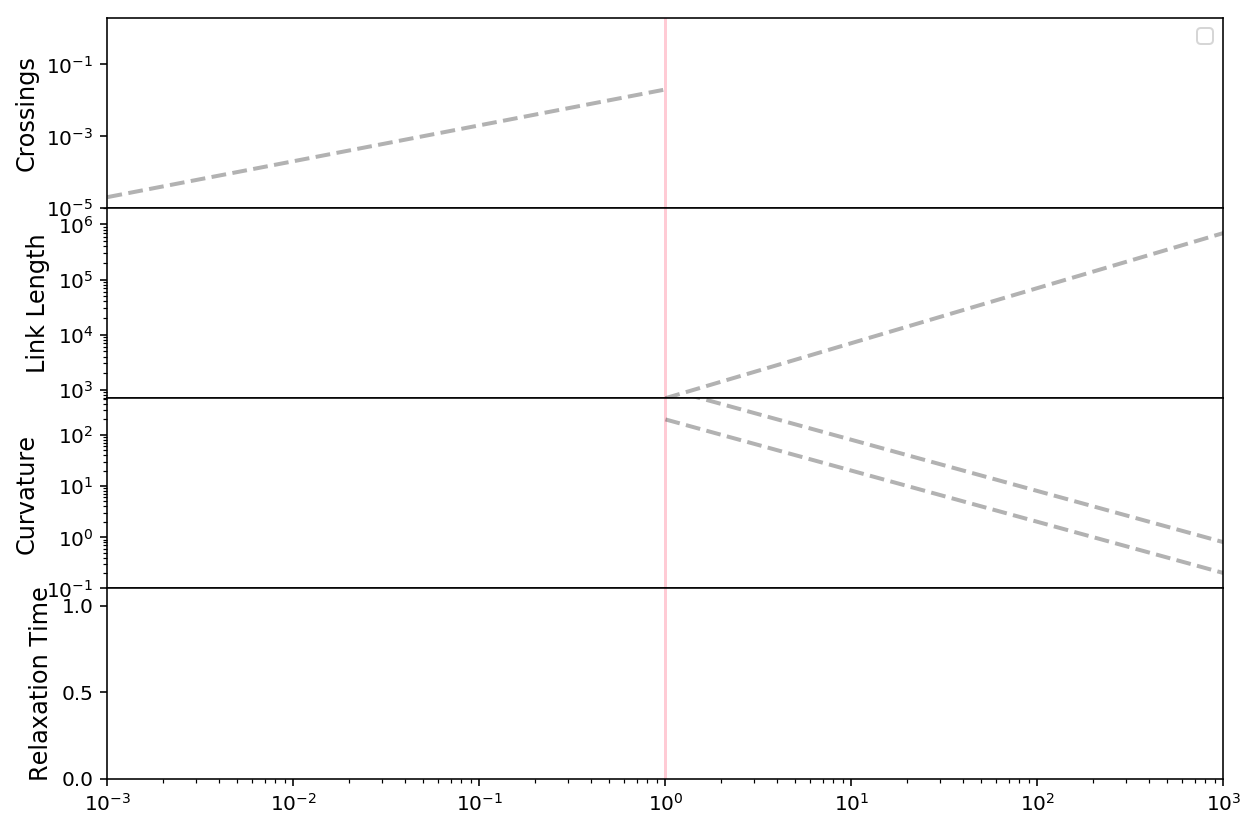

In [12]:

nn = 150#130#55
n1 = 4
fs = 12
x = logspace(0,3,5)
ep,h,h1 = 2e-2, 2e6,1e-1
mx = (1.0e-3,1.0e3)
cs = {'BA':(1,0),'ER':(.5,0),'Lat':(.2,10)}
y=array([1-ep,1+ep])
cl = ['#2a78cc','#f19317']
fig = figure(figsize=(10,7))
fig.subplots_adjust(hspace=0)
p = {'BA':'Scale-free', 'ER':'Random', 'Lat': 'Lattice'}
mk = {'BA':'*', 'ER':'o', 'Lat': '|'}
ms,lw =4,.7
a = .2
for k,t in stats2.items():
    if 'L397' not in k: continue
    try:
        ii=1
        kw = {'label' : 'FUEL '+p[k],'c':cl[0],'marker':mk[k],'ms':ms,'lw':lw}
        subplot(n1,1,ii);ii+=1
        crs = bin_dat1(t['th'],tanh(.03*cs[k][0]*t['th']),nn,scale='')
        shade(crs[-cs[k][1]:],falpha = a,**kw)
        yscale('log')
        subplot(n1,1,ii);ii+=1
        lz = bin_dat1(t['th'], t['lz'],nn)
        shade(lz,falpha = a,**kw)
        #plot(*lz.T[:2],**kw)
        subplot(n1,1,ii);ii+=1
        c = bin_dat1(t['th'], t['cur'],nn, scale='')#(nn if k != 'ER' else 20))
        shade(c,falpha = a,**kw)
        #plot(*c.T[:2],**kw)
        subplot(n1,1,ii);ii+=1
        t1 = (t['t']*t['lz']/maximum(1,t['th'])**2)
        t0 = bin_dat1(t['th'], t1/t1.max(),nn, scale='')
        shade(t0,falpha = a,**kw)
        #plot(*t0.T[:2],**kw)
    except TypeError:
        continue
for k,t in stats2_fx.items():
    if 'L397' not in k: continue
    try:
        ii=1
        kw = {'label' : 'ELI '+p[k],'c':cl[1],'marker':mk[k],'ms':ms,'lw':lw}
        subplot(n1,1,ii);ii+=1
        crs = bin_dat1(t['th'],tanh(.03*cs[k][0]*t['th']),nn,scale='')
        shade(crs[-cs[k][1]:],falpha = a,**kw)
        yscale('log')
        subplot(n1,1,ii);ii+=1
        lz = bin_dat1(t['th'], t['lz'],nn)
        shade(lz,falpha = a,**kw)
        #plot(*lz.T[:2],**kw)
        subplot(n1,1,ii);ii+=1
        c = bin_dat1(t['th'], t['cur'],nn, scale='')#(nn if k != 'ER' else 20))
        shade(c,falpha = a,**kw)
        #plot(*c.T[:2],**kw)
        subplot(n1,1,ii);ii+=1
        t1 = (t['t']*t['lz']/maximum(1,t['th'])**2)
        t0 = bin_dat1(t['th'], t1/t1.max(),nn, scale='')
        shade(t0,falpha = a,**kw)
        #plot(*t0.T[:2],**kw)
    except TypeError:
        continue

a = .3

x1 = logspace(-3,0,5)
ii = 1
subplot(n1,1,ii);ii+=1
fill_between(y,[h]*2, [.1e-4]*2, facecolor = '#ff5577', alpha = a)
plot(x1,2e-2*x1, 'k--', alpha = .3, lw=2)
ylabel('Crossings',fontsize=fs)
legend(ncol=2)
xscale('log')
yscale('log')
ylim(.1e-4,2e0)
xlim(*mx)
xticks([])

subplot(n1,1,ii);ii+=1
fill_between(y,[h]*2, [1]*2, facecolor = '#ff5577', alpha = a)
plot(x,7e2*x, 'k--', alpha = .3, lw=2)
ylabel('Link Length',fontsize=fs)
# legend(ncol=2)
xscale('log')
yscale('log')
ylim(.7e3,h)
xlim(*mx)
xticks([])

subplot(n1,1,ii);ii+=1
fill_between(y,[h]*2, [h1]*2, facecolor = '#ff5577', alpha = a)
plot(x,2e2/x, 'k--', alpha = .3, lw=2)
plot(x,8e2/x, 'k--', alpha = .3, lw=2)
ylabel('Curvature',fontsize=fs)
xscale('log')
yscale('log')
ylim(h1,5.2e2)
xlim(*mx)
xticks([])

subplot(n1,1,ii);ii+=1
fill_between(y,[h,h], [1e-5,1e-5], facecolor = '#ff5577', alpha = a)
ylabel('Relaxation Time',fontsize=fs)
xscale('log')
# yscale('log')
#ylim(1e0,2.5e4)
# ylim(0e0,.5e4)
ylim(0,1.1)
# ylim(1e-3,2)
xlim(*mx)
# yscale('log')

In [59]:
stats2.keys()

['Lat', 'BA', 'ER']

# 032418

(0.001, 1000.0)

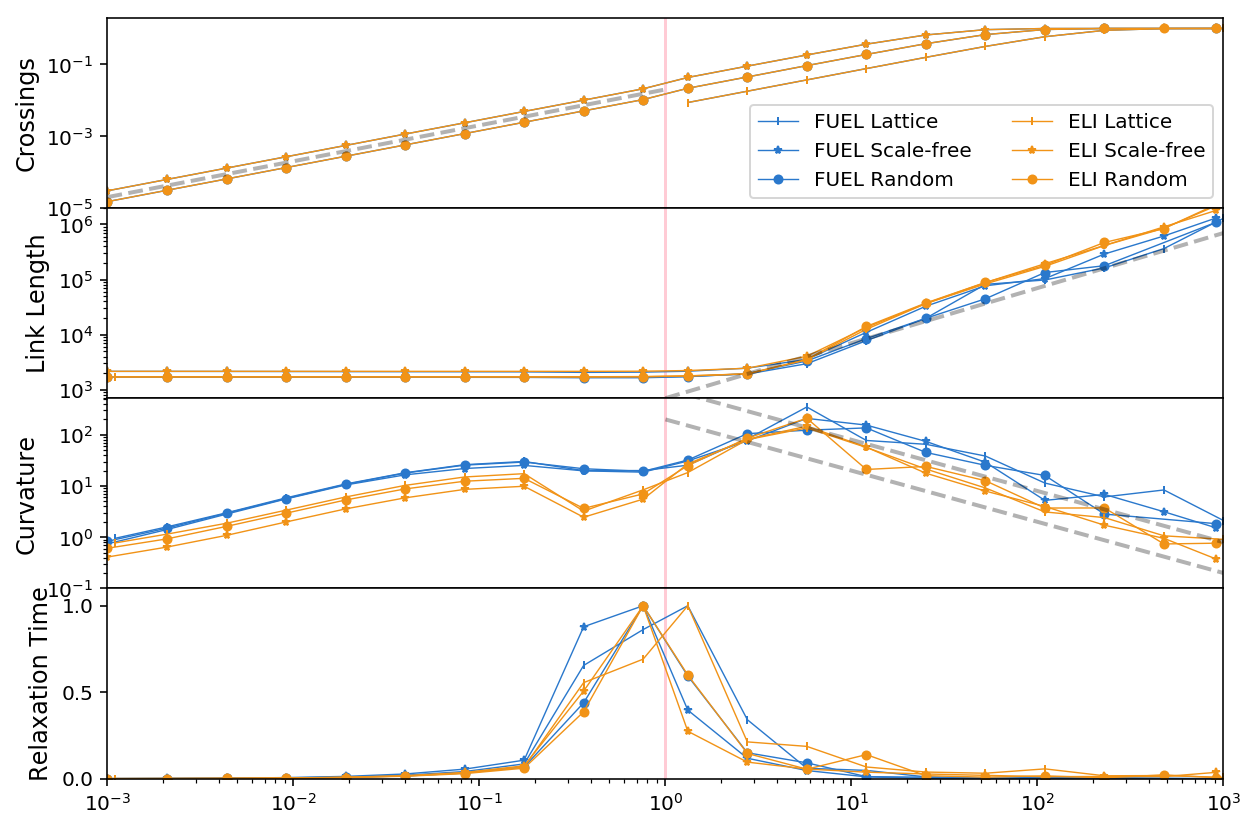

In [60]:

nn = 150#130#55
n1 = 4
fs = 12
x = logspace(0,3,5)
ep,h,h1 = 2e-2, 2e6,1e-1
mx = (1.0e-3,1.0e3)
cs = {'BA':(1,0),'ER':(.5,0),'Lat':(.2,10)}
y=array([1-ep,1+ep])
cl = ['#2a78cc','#f19317']
fig = figure(figsize=(10,7))
fig.subplots_adjust(hspace=0)
p = {'BA':'Scale-free', 'ER':'Random', 'Lat': 'Lattice'}
mk = {'BA':'*', 'ER':'o', 'Lat': '|'}
ms,lw =4,.7
a = .2
for k,t in stats2.items():
    try:
        ii=1
        kw = {'label' : 'FUEL '+p[k],'c':cl[0],'marker':mk[k],'ms':ms,'lw':lw}
        subplot(n1,1,ii);ii+=1
        crs = bin_dat1(t['th'],tanh(.03*cs[k][0]*t['th']),nn,scale='')
        shade(crs[-cs[k][1]:],falpha = a,**kw)
        yscale('log')
        subplot(n1,1,ii);ii+=1
        lz = bin_dat1(t['th'], t['lz'],nn)
        shade(lz,falpha = a,**kw)
        #plot(*lz.T[:2],**kw)
        subplot(n1,1,ii);ii+=1
        c = bin_dat1(t['th'], t['cur'],nn, scale='')#(nn if k != 'ER' else 20))
        shade(c,falpha = a,**kw)
        #plot(*c.T[:2],**kw)
        subplot(n1,1,ii);ii+=1
        t1 = (t['t']*t['lz']/maximum(1,t['th'])**2)
        t0 = bin_dat1(t['th'], t1/t1.max(),nn, scale='')
        shade(t0,falpha = a,**kw)
        #plot(*t0.T[:2],**kw)
    except TypeError:
        continue
for k,t in stats2_fx.items():
    try:
        ii=1
        kw = {'label' : 'ELI '+p[k],'c':cl[1],'marker':mk[k],'ms':ms,'lw':lw}
        subplot(n1,1,ii);ii+=1
        crs = bin_dat1(t['th'],tanh(.03*cs[k][0]*t['th']),nn,scale='')
        shade(crs[-cs[k][1]:],falpha = a,**kw)
        yscale('log')
        subplot(n1,1,ii);ii+=1
        lz = bin_dat1(t['th'], t['lz'],nn)
        shade(lz,falpha = a,**kw)
        #plot(*lz.T[:2],**kw)
        subplot(n1,1,ii);ii+=1
        c = bin_dat1(t['th'], t['cur'],nn, scale='')#(nn if k != 'ER' else 20))
        shade(c,falpha = a,**kw)
        #plot(*c.T[:2],**kw)
        subplot(n1,1,ii);ii+=1
        t1 = (t['t']*t['lz']/maximum(1,t['th'])**2)
        t0 = bin_dat1(t['th'], t1/t1.max(),nn, scale='')
        shade(t0,falpha = a,**kw)
        #plot(*t0.T[:2],**kw)
    except TypeError:
        continue

a = .3

x1 = logspace(-3,0,5)
ii = 1
subplot(n1,1,ii);ii+=1
fill_between(y,[h]*2, [.1e-4]*2, facecolor = '#ff5577', alpha = a)
plot(x1,2e-2*x1, 'k--', alpha = .3, lw=2)
ylabel('Crossings',fontsize=fs)
legend(ncol=2)
xscale('log')
yscale('log')
ylim(.1e-4,2e0)
xlim(*mx)
xticks([])

subplot(n1,1,ii);ii+=1
fill_between(y,[h]*2, [1]*2, facecolor = '#ff5577', alpha = a)
plot(x,7e2*x, 'k--', alpha = .3, lw=2)
ylabel('Link Length',fontsize=fs)
# legend(ncol=2)
xscale('log')
yscale('log')
ylim(.7e3,h)
xlim(*mx)
xticks([])

subplot(n1,1,ii);ii+=1
fill_between(y,[h]*2, [h1]*2, facecolor = '#ff5577', alpha = a)
plot(x,2e2/x, 'k--', alpha = .3, lw=2)
plot(x,8e2/x, 'k--', alpha = .3, lw=2)
ylabel('Curvature',fontsize=fs)
xscale('log')
yscale('log')
ylim(h1,5.2e2)
xlim(*mx)
xticks([])

subplot(n1,1,ii);ii+=1
fill_between(y,[h,h], [1e-5,1e-5], facecolor = '#ff5577', alpha = a)
ylabel('Relaxation Time',fontsize=fs)
xscale('log')
# yscale('log')
#ylim(1e0,2.5e4)
# ylim(0e0,.5e4)
ylim(0,1.1)
# ylim(1e-3,2)
xlim(*mx)
# yscale('log')

In [42]:
t = stats2_fx['ER']#.keys()

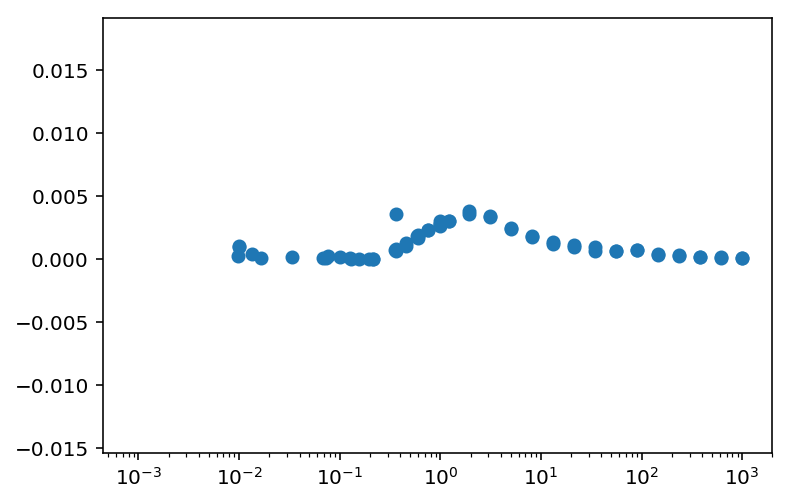

In [42]:
scatter(t['th'], t['wz']/t['th'])
xscale('log')
# yscale('log')

In [17]:
idx = where(t['wz']/t['th'] < .5)

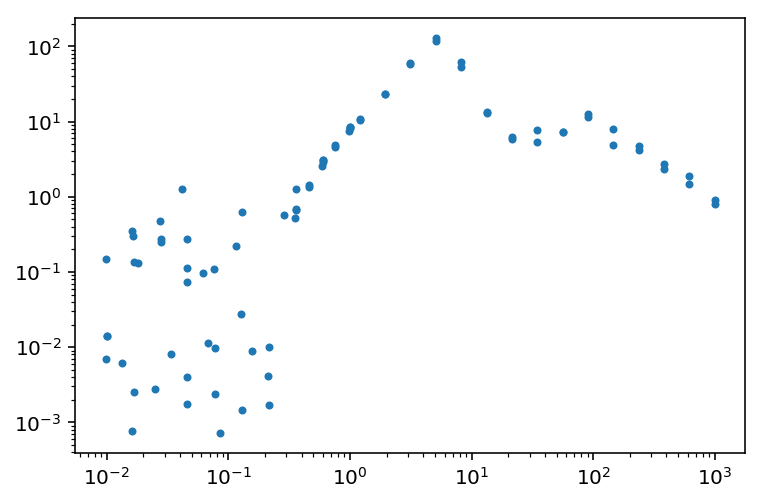

In [18]:
plot(t['th'][idx], t['cur'][idx],'.')
xscale('log')
yscale('log')

In [22]:
t.keys()

['ka', 'cur', 'lz0', 'l', 'nam', 'a1', 'a2', 't', 'th', 'v', 'lz', 'wz']

(0.009, 1000.0)

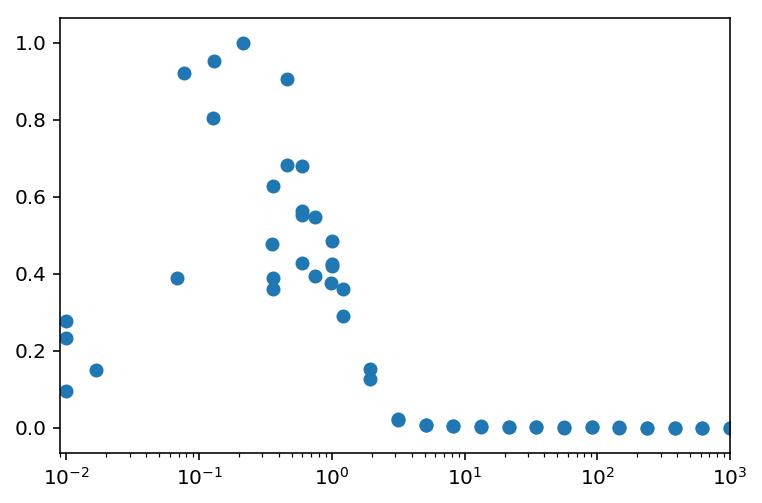

In [26]:
t1 = (t['t']*t['lz']/maximum(1,t['th'])**2)
scatter(t['th'], t1/t1.max())
xscale('log')
#yscale('log')
xlim(9e-3,1e3)

In [30]:
l = os.listdir('/home/nidami/3d/output/phase-101817/')

In [35]:
l1 = [i for i in l if ('ER' in i) and ('th-r0.0' in i) and ('fixed' in i) and ('.json' in i)]
len(l1)

42

# Both

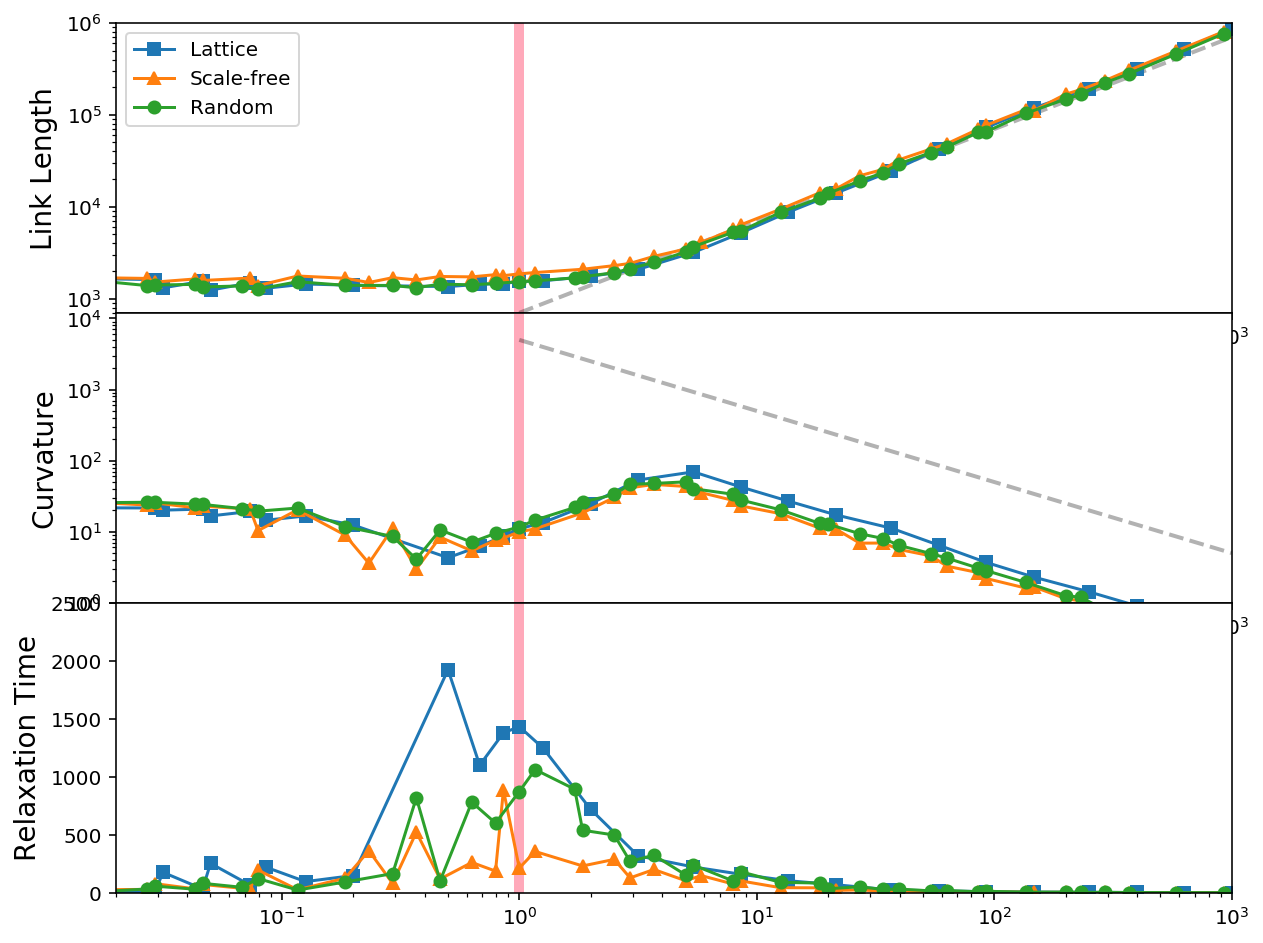

In [88]:

nn = 150#55
n1 = 3
fs = 14
x = logspace(0,3,5)
ep,h,h1 = 5e-2, 1e6,1e-0
y=array([1-ep,1+ep])
mk = {'BA':'^','ER':'o', 'Lat':'s'}

fig = figure(figsize=(10,8))
fig.subplots_adjust(hspace=0)
subplot(n1,1,1)
fill_between(y,[h,h], [1,1], facecolor = '#ff5577', alpha = .5)
plot(x,7e2*x, 'k--', alpha = .3, lw=2)
ylabel('Link Length',fontsize=fs)
subplot(n1,1,2)
fill_between(y,[h,h], [h1,h1], facecolor = '#ff5577', alpha = .5)
plot(x,5e3/x, 'k--', alpha = .3, lw=2)
ylabel('Curvature',fontsize=fs)
subplot(n1,1,3)
fill_between(y,[h,h], [1,1], facecolor = '#ff5577', alpha = .5)
ylabel('Relaxation Time',fontsize=fs)
mx = (2e-2,1.0e3)
p = {'BA':'Scale-free', 'ER':'Random', 'Lat': 'Lattice'}
for k,t in stats2.items():
    subplot(n1,1,1)
    lz = bin_dat1(t['th'], t['lz'],nn)
    #shade(lz,label = p[k],marker='.')
    plot(*lz.T[:2],label = p[k],marker=mk[k])
    xscale('log')
    yscale('log')
    ylim(.7e3,1e6)
    xlim(*mx)
    
    subplot(n1,1,2)
    c = bin_dat1(t['th'], t['cur'],nn)#(nn if k != 'ER' else 20))
    #shade(c,label = p[k],marker='.')
    plot(*c.T[:2],label = p[k],marker=mk[k])
    xscale('log')
    yscale('log')
    ylim(h1,1.2e4)
    xlim(*mx)
    
    subplot(n1,1,3)
    t0 = bin_dat1(t['th'], (t['t']/maximum(1,t['th'])),nn)
    #shade(t0,label = p[k],marker='.')
    plot(*t0.T[:2],label = p[k],marker=mk[k])
    xscale('log')
    ylim(0,2.5e3)
    xlim(*mx)
    
    
subplot(n1,1,1)
legend()


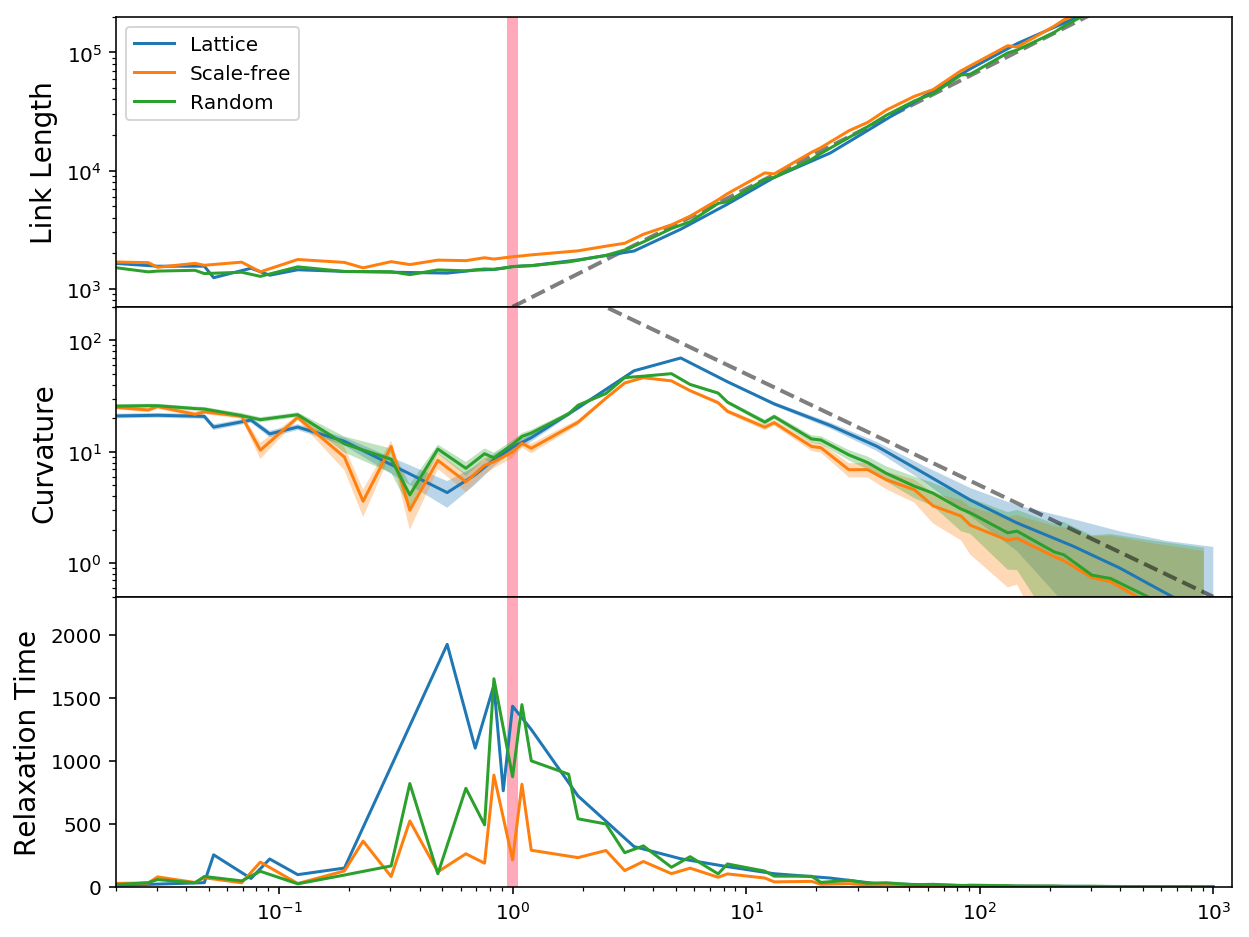

In [89]:

nn = 125
n1 = 3
fs = 14
x = logspace(0,3,5)
ep,h = 5e-2, 1e6
y=array([1-ep,1+ep])

fig = figure(figsize=(10,8))
fig.subplots_adjust(hspace=0)
subplot(n1,1,1)
fill_between(y,[h,h], [1,1], facecolor = '#ff5577', alpha = .5)
plot(x,7e2*x, 'k--', alpha = .5, lw=2)
ylabel('Link Length',fontsize=fs)
subplot(n1,1,2)
fill_between(y,[h,h], [.1,.1], facecolor = '#ff5577', alpha = .5)
plot(x,5e2/x, 'k--', alpha = .5, lw=2)
ylabel('Curvature',fontsize=fs)
subplot(n1,1,3)
fill_between(y,[h,h], [1,1], facecolor = '#ff5577', alpha = .5)
ylabel('Relaxation Time',fontsize=fs)
mx = (2e-2,1.2e3)
p = {'BA':'Scale-free', 'ER':'Random', 'Lat': 'Lattice'}
for k,t in stats2.items():
    subplot(n1,1,1)
    lz = bin_dat1(t['th'], t['lz'],nn)
    shade(lz,label = p[k])
    yscale('log')
    ylim(.7e3,2e5)
    xlim(*mx)
    
    subplot(n1,1,2)
    c = bin_dat1(t['th'], t['cur'],nn)#(nn if k != 'ER' else 20))
    shade(c,label = p[k])
    yscale('log')
    ylim(5e-1,2e2)
    xlim(*mx)
    
    subplot(n1,1,3)
    t0 = bin_dat1(t['th'], (t['t']/maximum(1,t['th'])),nn)
    shade(t0,label = p[k])
    ylim(0,2.3e3)
    xlim(*mx)
    
    
subplot(n1,1,1)
legend()


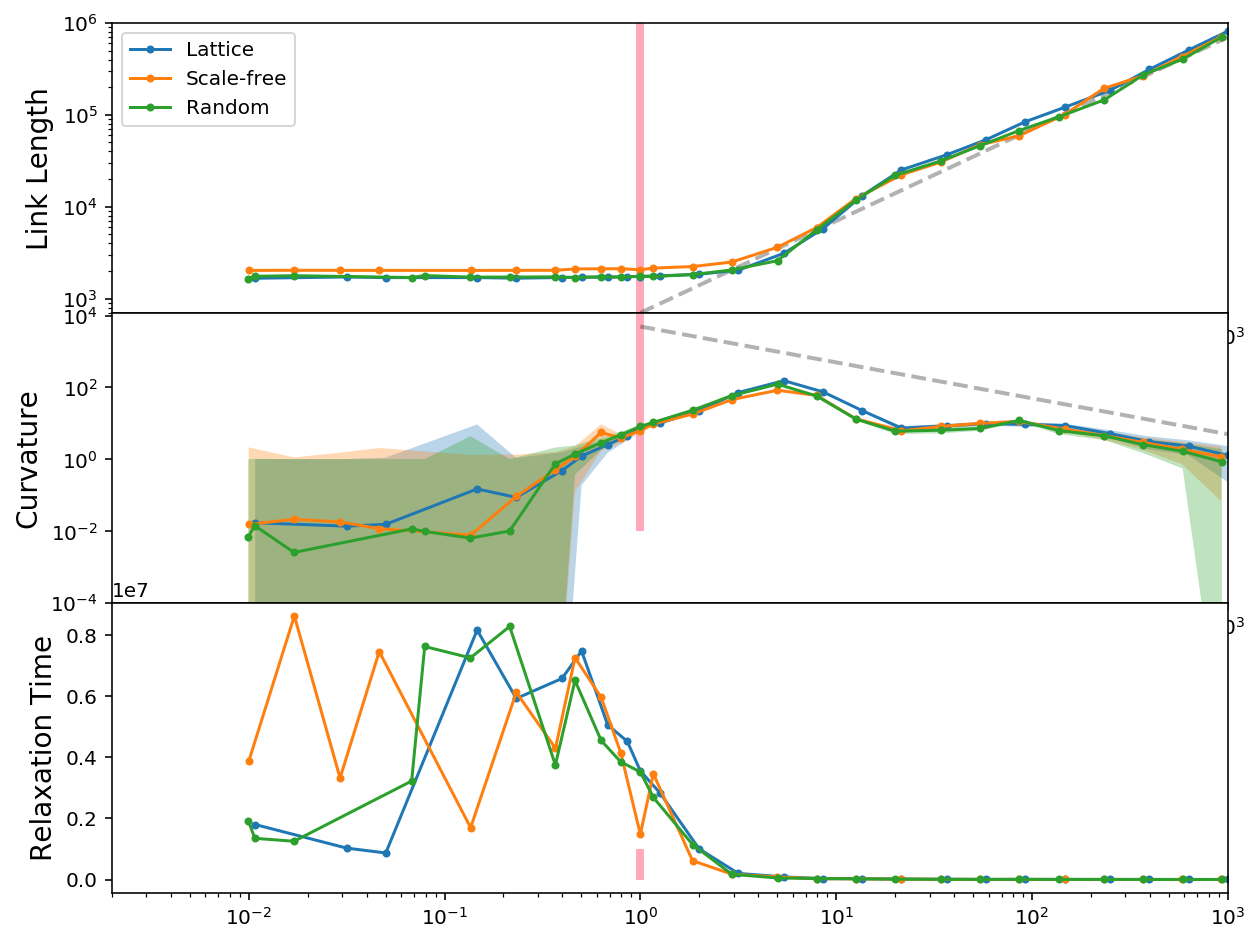

In [90]:

nn = 150
n1 = 3
fs = 14
x = logspace(0,3,5)
ep,h = 5e-2, 1e6
y=array([1-ep,1+ep])

fig = figure(figsize=(10,8))
fig.subplots_adjust(hspace=0)
subplot(n1,1,1)
fill_between(y,[h,h], [1,1], facecolor = '#ff5577', alpha = .5)
plot(x,7e2*x, 'k--', alpha = .3, lw=2)
ylabel('Link Length',fontsize=fs)
subplot(n1,1,2)
fill_between(y,[h,h], [1e-2,1e-2], facecolor = '#ff5577', alpha = .5)
plot(x,5e3/x, 'k--', alpha = .3, lw=2)
ylabel('Curvature',fontsize=fs)
subplot(n1,1,3)
fill_between(y,[h,h], [1,1], facecolor = '#ff5577', alpha = .5)
ylabel('Relaxation Time',fontsize=fs)
mx = (2e-3,1.0e3)
p = {'BA':'Scale-free', 'ER':'Random', 'Lat': 'Lattice'}
for k,t in stats2_fx.items():
    subplot(n1,1,1)
    lz = bin_dat1(t['th'], t['lz'],nn)
    shade(lz,label = p[k],marker='.')
    yscale('log')
    ylim(.7e3,1e6)
    xlim(*mx)
    
    subplot(n1,1,2)
    c = bin_dat1(t['th'], t['cur'],nn)#(nn if k != 'ER' else 20))
    shade(c,label = p[k],marker='.')
    yscale('log')
    ylim(1e-4,1.2e4)
    xlim(*mx)
    
    subplot(n1,1,3)
    #t0 = bin_dat1(t['th'], (t['t']/maximum(1,t['th'])),nn)
    t0 = bin_dat1(t['th'], (t['t']*t['lz']/maximum(1,t['th'])**2),nn)
    shade(t0,label = p[k],marker='.')
    #ylim(-1e2,5.5e3)
    #ylim(0,4.5)
    #yscale('log')
    
    xlim(*mx)
    
    
subplot(n1,1,1)
legend()


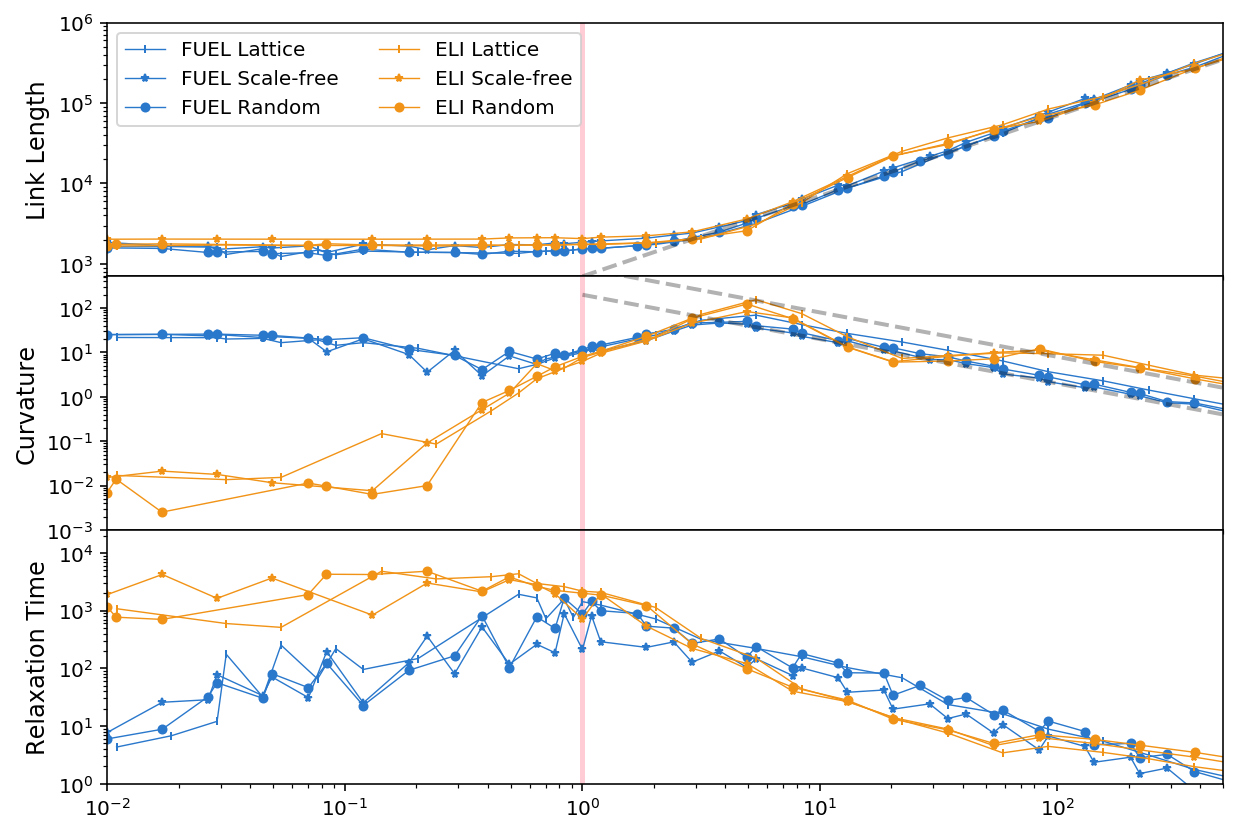

In [91]:

nn = 130#55
n1 = 3
fs = 12
x = logspace(0,3,5)
ep,h,h1 = 2e-2, 1e6,1e-3
mx = (1e-2,5.0e2)

y=array([1-ep,1+ep])
cl = ['#2a78cc','#f19317']
fig = figure(figsize=(10,7))
fig.subplots_adjust(hspace=0)
p = {'BA':'Scale-free', 'ER':'Random', 'Lat': 'Lattice'}
mk = {'BA':'*', 'ER':'o', 'Lat': '|'}
ms,lw =4,.7

for k,t in stats2.items():
    kw = {'label' : 'FUEL '+p[k],'c':cl[0],'marker':mk[k],'ms':ms,'lw':lw}
    subplot(n1,1,1)
    lz = bin_dat1(t['th'], t['lz'],nn)
    plot(*lz.T[:2],**kw)
    subplot(n1,1,2)
    c = bin_dat1(t['th'], t['cur'],nn)#(nn if k != 'ER' else 20))
    plot(*c.T[:2],**kw)
    subplot(n1,1,3)
    t0 = bin_dat1(t['th'], (t['t']/maximum(1,t['th'])),nn)
    plot(*t0.T[:2],**kw)
    
for k,t in stats2_fx.items():
    kw = {'label' : 'ELI '+p[k],'c':cl[1],'marker':mk[k],'ms':ms,'lw':lw}
    subplot(n1,1,1)
    lz = bin_dat1(t['th'], t['lz'],nn)
    plot(*lz.T[:2],**kw)
    subplot(n1,1,2)
    c = bin_dat1(t['th'], t['cur'],nn)#(nn if k != 'ER' else 20))
    plot(*c.T[:2],**kw)
    subplot(n1,1,3)
    t0 = bin_dat1(t['th'], (t['t']/maximum(1,t['th'])),nn)
    plot(*t0.T[:2],**kw)

a = .3
subplot(n1,1,1)
fill_between(y,[h,h], [1,1], facecolor = '#ff5577', alpha = a)
plot(x,7e2*x, 'k--', alpha = .3, lw=2)
ylabel('Link Length',fontsize=fs)
legend(ncol=2)
xscale('log')
yscale('log')
ylim(.7e3,1e6)
xlim(*mx)
xticks([])

subplot(n1,1,2)
fill_between(y,[h,h], [h1,h1], facecolor = '#ff5577', alpha = a)
plot(x,2e2/x, 'k--', alpha = .3, lw=2)
plot(x,8e2/x, 'k--', alpha = .3, lw=2)
ylabel('Curvature',fontsize=fs)
xscale('log')
yscale('log')
ylim(h1,5.2e2)
xlim(*mx)
xticks([])

subplot(n1,1,3)
fill_between(y,[h,h], [1,1], facecolor = '#ff5577', alpha = a)
ylabel('Relaxation Time',fontsize=fs)
xscale('log')
ylim(1e0,2.5e4)
xlim(*mx)
yscale('log')

(0.01, 500.0)

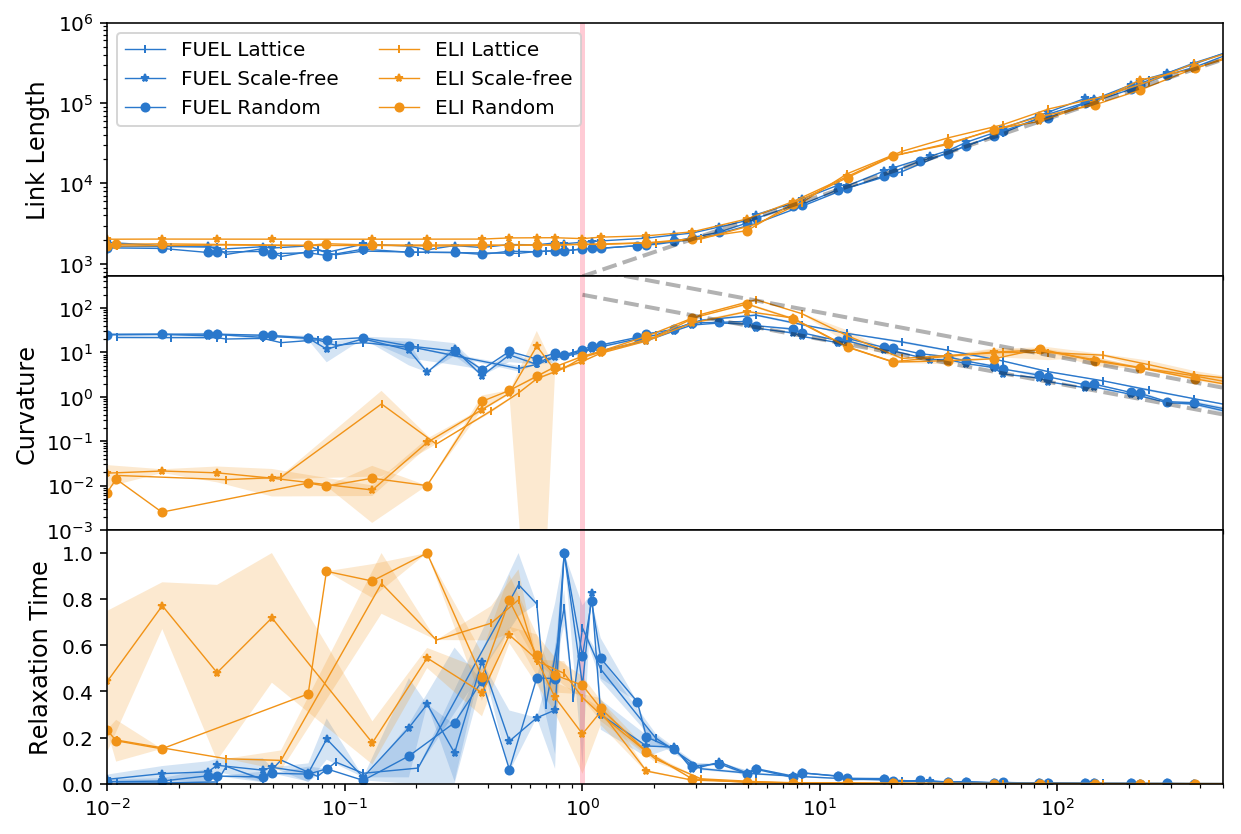

In [92]:

nn = 130#55
n1 = 3
fs = 12
x = logspace(0,3,5)
ep,h,h1 = 2e-2, 1e6,1e-3
mx = (1e-2,5.0e2)

y=array([1-ep,1+ep])
cl = ['#2a78cc','#f19317']
fig = figure(figsize=(10,7))
fig.subplots_adjust(hspace=0)
p = {'BA':'Scale-free', 'ER':'Random', 'Lat': 'Lattice'}
mk = {'BA':'*', 'ER':'o', 'Lat': '|'}
ms,lw =4,.7
a = .2

for k,t in stats2.items():
    kw = {'label' : 'FUEL '+p[k],'c':cl[0],'marker':mk[k],'ms':ms,'lw':lw}
    subplot(n1,1,1)
    lz = bin_dat1(t['th'], t['lz'],nn)
    shade(lz,falpha = a,**kw)
    #plot(*lz.T[:2],**kw)
    subplot(n1,1,2)
    c = bin_dat1(t['th'], t['cur'],nn, scale='')#(nn if k != 'ER' else 20))
    shade(c,falpha = a,**kw)
    #plot(*c.T[:2],**kw)
    subplot(n1,1,3)
    t1 = (t['t']*t['lz']/maximum(1,t['th'])**2)
    t0 = bin_dat1(t['th'], t1/t1.max(),nn, scale='')
    shade(t0,falpha = a,**kw)
    #plot(*t0.T[:2],**kw)
    
for k,t in stats2_fx.items():
    kw = {'label' : 'ELI '+p[k],'c':cl[1],'marker':mk[k],'ms':ms,'lw':lw}
    subplot(n1,1,1)
    lz = bin_dat1(t['th'], t['lz'],nn)
    shade(lz,falpha = a,**kw)
    #plot(*lz.T[:2],**kw)
    subplot(n1,1,2)
    c = bin_dat1(t['th'], t['cur'],nn, scale='')#(nn if k != 'ER' else 20))
    shade(c,falpha = a,**kw)
    #plot(*c.T[:2],**kw)
    subplot(n1,1,3)
    t1 = (t['t']*t['lz']/maximum(1,t['th'])**2)
    t0 = bin_dat1(t['th'], t1/t1.max(),nn, scale='')
    shade(t0,falpha = a,**kw)
    #plot(*t0.T[:2],**kw)

a = .3
subplot(n1,1,1)
fill_between(y,[h,h], [1,1], facecolor = '#ff5577', alpha = a)
plot(x,7e2*x, 'k--', alpha = .3, lw=2)
ylabel('Link Length',fontsize=fs)
legend(ncol=2)
xscale('log')
yscale('log')
ylim(.7e3,1e6)
xlim(*mx)
xticks([])

subplot(n1,1,2)
fill_between(y,[h,h], [h1,h1], facecolor = '#ff5577', alpha = a)
plot(x,2e2/x, 'k--', alpha = .3, lw=2)
plot(x,8e2/x, 'k--', alpha = .3, lw=2)
ylabel('Curvature',fontsize=fs)
xscale('log')
yscale('log')
ylim(h1,5.2e2)
xlim(*mx)
xticks([])

subplot(n1,1,3)
fill_between(y,[h,h], [1e-5,1e-5], facecolor = '#ff5577', alpha = a)
ylabel('Relaxation Time',fontsize=fs)
xscale('log')
#ylim(1e0,2.5e4)
#ylim(0e0,.5e4)
ylim(0,1.1)

xlim(*mx)
#yscale('log')

(0.01, 500.0)

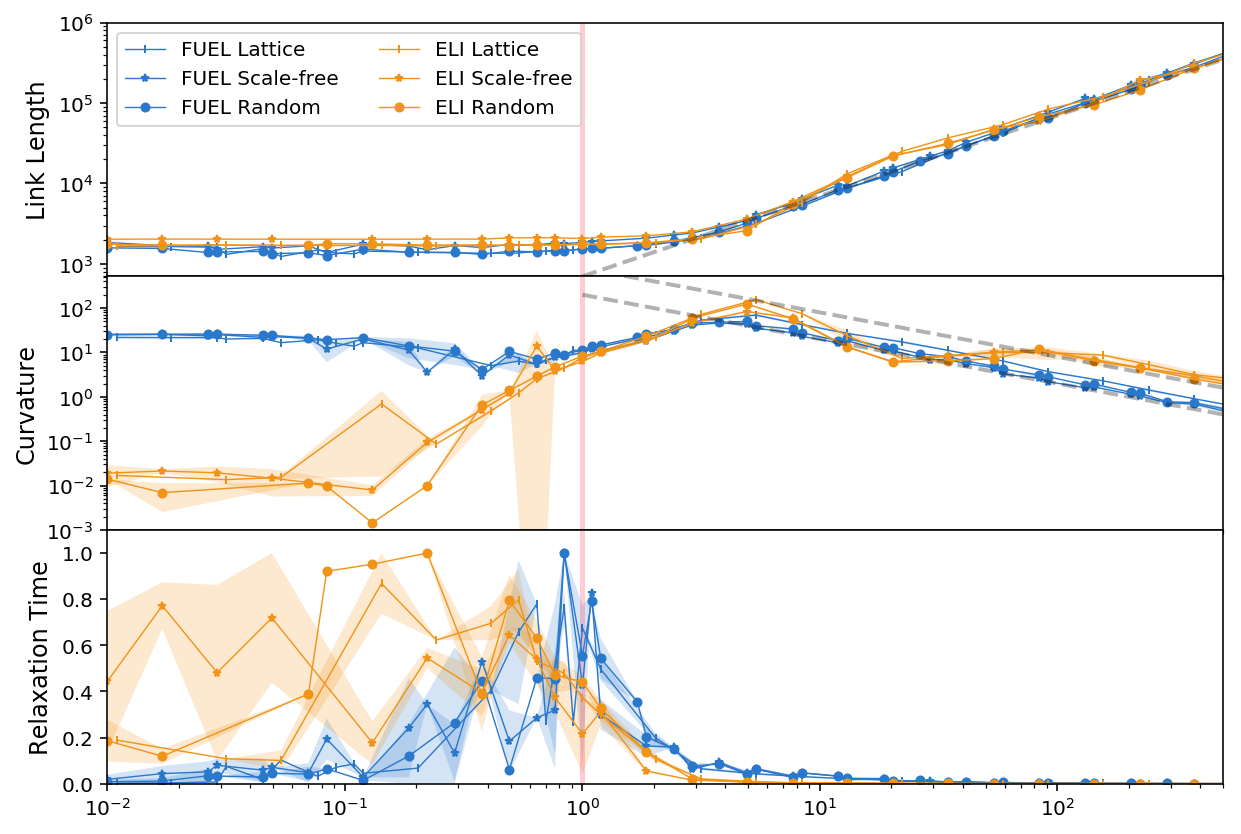

In [85]:

nn = 130#55
n1 = 3
fs = 12
x = logspace(0,3,5)
ep,h,h1 = 2e-2, 1e6,1e-3
mx = (1e-2,5.0e2)

y=array([1-ep,1+ep])
cl = ['#2a78cc','#f19317']
fig = figure(figsize=(10,7))
fig.subplots_adjust(hspace=0)
p = {'BA':'Scale-free', 'ER':'Random', 'Lat': 'Lattice'}
mk = {'BA':'*', 'ER':'o', 'Lat': '|'}
ms,lw =4,.7
a = .2

for k,t in stats2.items():
    kw = {'label' : 'FUEL '+p[k],'c':cl[0],'marker':mk[k],'ms':ms,'lw':lw}
    subplot(n1,1,1)
    lz = bin_dat1(t['th'], t['lz'],nn)
    shade(lz,falpha = a,**kw)
    #plot(*lz.T[:2],**kw)
    subplot(n1,1,2)
    c = bin_dat1(t['th'], t['cur'],nn, scale='')#(nn if k != 'ER' else 20))
    shade(c,falpha = a,**kw)
    #plot(*c.T[:2],**kw)
    subplot(n1,1,3)
    t1 = (t['t']*t['lz']/maximum(1,t['th'])**2)
    t0 = bin_dat1(t['th'], t1/t1.max(),nn, scale='')
    shade(t0,falpha = a,**kw)
    #plot(*t0.T[:2],**kw)
    
for k,t in stats2_fx.items():
    kw = {'label' : 'ELI '+p[k],'c':cl[1],'marker':mk[k],'ms':ms,'lw':lw}
    subplot(n1,1,1)
    lz = bin_dat1(t['th'], t['lz'],nn)
    shade(lz,falpha = a,**kw)
    #plot(*lz.T[:2],**kw)
    subplot(n1,1,2)
    c = bin_dat1(t['th'], t['cur'],nn, scale='')#(nn if k != 'ER' else 20))
    shade(c,falpha = a,**kw)
    #plot(*c.T[:2],**kw)
    subplot(n1,1,3)
    t1 = (t['t']*t['lz']/maximum(1,t['th'])**2)
    t0 = bin_dat1(t['th'], t1/t1.max(),nn, scale='')
    shade(t0,falpha = a,**kw)
    #plot(*t0.T[:2],**kw)

a = .3
subplot(n1,1,1)
fill_between(y,[h,h], [1,1], facecolor = '#ff5577', alpha = a)
plot(x,7e2*x, 'k--', alpha = .3, lw=2)
ylabel('Link Length',fontsize=fs)
legend(ncol=2)
xscale('log')
yscale('log')
ylim(.7e3,1e6)
xlim(*mx)
xticks([])

subplot(n1,1,2)
fill_between(y,[h,h], [h1,h1], facecolor = '#ff5577', alpha = a)
plot(x,2e2/x, 'k--', alpha = .3, lw=2)
plot(x,8e2/x, 'k--', alpha = .3, lw=2)
ylabel('Curvature',fontsize=fs)
xscale('log')
yscale('log')
ylim(h1,5.2e2)
xlim(*mx)
xticks([])

subplot(n1,1,3)
fill_between(y,[h,h], [1e-5,1e-5], facecolor = '#ff5577', alpha = a)
ylabel('Relaxation Time',fontsize=fs)
xscale('log')
#ylim(1e0,2.5e4)
#ylim(0e0,.5e4)
ylim(0,1.1)

xlim(*mx)
#yscale('log')

In [34]:
1/rs(70,140)

2.870987739370741

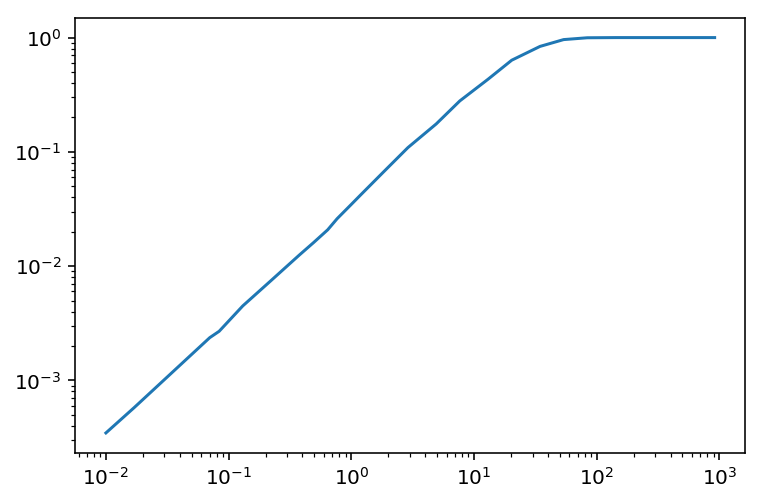

In [35]:
crs = bin_dat1(t['th'],tanh(.1*rs(70,140)*t['th']),nn,scale='')
shade(crs)
yscale('log')

(0.01, 500.0)

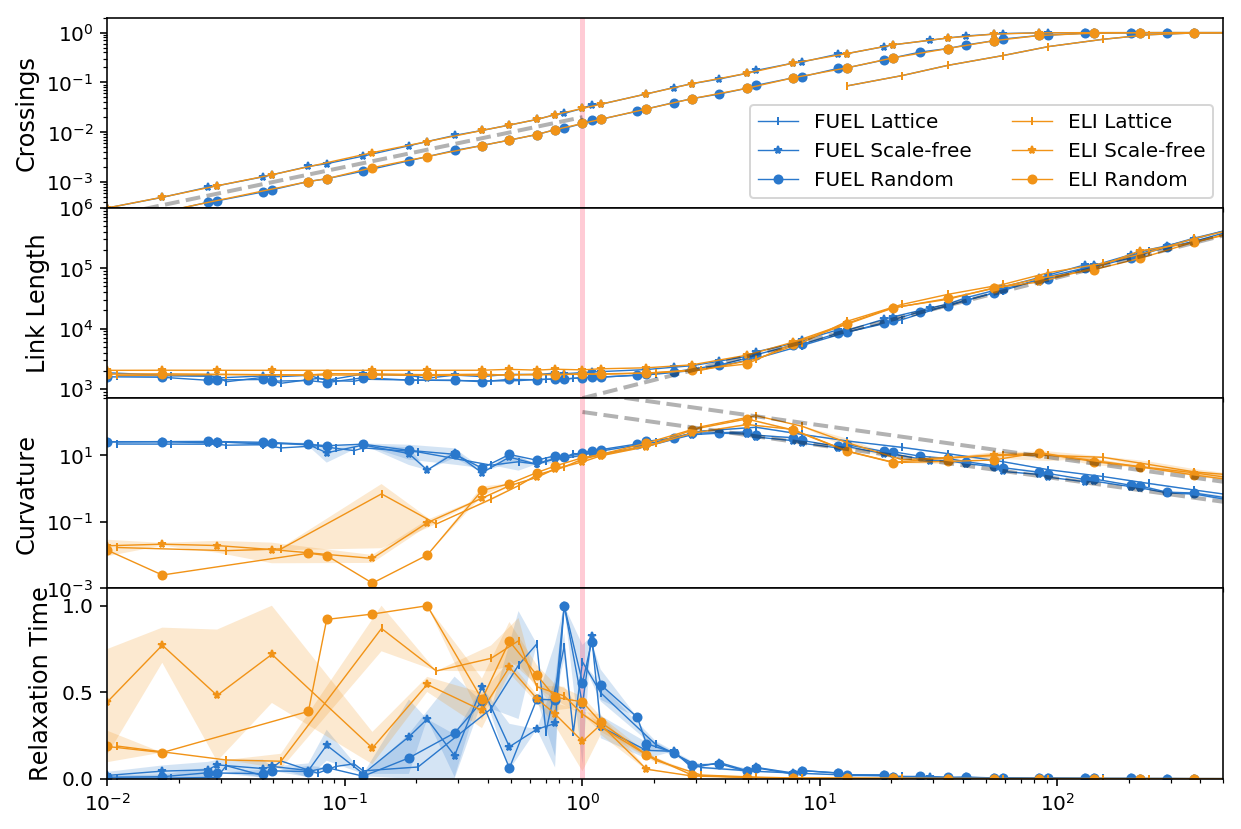

In [77]:

nn = 130#55
n1 = 4
fs = 12
x = logspace(0,3,5)
ep,h,h1 = 2e-2, 1e6,1e-3
mx = (1e-2,5.0e2)
cs = {'BA':(1,0),'ER':(.5,0),'Lat':(.2,10)}
y=array([1-ep,1+ep])
cl = ['#2a78cc','#f19317']
fig = figure(figsize=(10,7))
fig.subplots_adjust(hspace=0)
p = {'BA':'Scale-free', 'ER':'Random', 'Lat': 'Lattice'}
mk = {'BA':'*', 'ER':'o', 'Lat': '|'}
ms,lw =4,.7
a = .2
for k,t in stats2.items():
    ii=1
    kw = {'label' : 'FUEL '+p[k],'c':cl[0],'marker':mk[k],'ms':ms,'lw':lw}
    subplot(n1,1,ii);ii+=1
    crs = bin_dat1(t['th'],tanh(.03*cs[k][0]*t['th']),nn,scale='')
    shade(crs[-cs[k][1]:],falpha = a,**kw)
    yscale('log')
    subplot(n1,1,ii);ii+=1
    lz = bin_dat1(t['th'], t['lz'],nn)
    shade(lz,falpha = a,**kw)
    #plot(*lz.T[:2],**kw)
    subplot(n1,1,ii);ii+=1
    c = bin_dat1(t['th'], t['cur'],nn, scale='')#(nn if k != 'ER' else 20))
    shade(c,falpha = a,**kw)
    #plot(*c.T[:2],**kw)
    subplot(n1,1,ii);ii+=1
    t1 = (t['t']*t['lz']/maximum(1,t['th'])**2)
    t0 = bin_dat1(t['th'], t1/t1.max(),nn, scale='')
    shade(t0,falpha = a,**kw)
    #plot(*t0.T[:2],**kw)
for k,t in stats2_fx.items():
    ii=1
    kw = {'label' : 'ELI '+p[k],'c':cl[1],'marker':mk[k],'ms':ms,'lw':lw}
    subplot(n1,1,ii);ii+=1
    crs = bin_dat1(t['th'],tanh(.03*cs[k][0]*t['th']),nn,scale='')
    shade(crs[-cs[k][1]:],falpha = a,**kw)
    yscale('log')
    subplot(n1,1,ii);ii+=1
    lz = bin_dat1(t['th'], t['lz'],nn)
    shade(lz,falpha = a,**kw)
    #plot(*lz.T[:2],**kw)
    subplot(n1,1,ii);ii+=1
    c = bin_dat1(t['th'], t['cur'],nn, scale='')#(nn if k != 'ER' else 20))
    shade(c,falpha = a,**kw)
    #plot(*c.T[:2],**kw)
    subplot(n1,1,ii);ii+=1
    t1 = (t['t']*t['lz']/maximum(1,t['th'])**2)
    t0 = bin_dat1(t['th'], t1/t1.max(),nn, scale='')
    shade(t0,falpha = a,**kw)
    #plot(*t0.T[:2],**kw)

a = .3

x1 = logspace(-3,0,5)
ii = 1
subplot(n1,1,ii);ii+=1
fill_between(y,[h,h], [1e-4,1e-4], facecolor = '#ff5577', alpha = a)
plot(x1,2e-2*x1, 'k--', alpha = .3, lw=2)
ylabel('Crossings',fontsize=fs)
legend(ncol=2)
xscale('log')
yscale('log')
ylim(3e-4,2e0)
xlim(*mx)
xticks([])

subplot(n1,1,ii);ii+=1
fill_between(y,[h,h], [1,1], facecolor = '#ff5577', alpha = a)
plot(x,7e2*x, 'k--', alpha = .3, lw=2)
ylabel('Link Length',fontsize=fs)
# legend(ncol=2)
xscale('log')
yscale('log')
ylim(.7e3,1e6)
xlim(*mx)
xticks([])

subplot(n1,1,ii);ii+=1
fill_between(y,[h,h], [h1,h1], facecolor = '#ff5577', alpha = a)
plot(x,2e2/x, 'k--', alpha = .3, lw=2)
plot(x,8e2/x, 'k--', alpha = .3, lw=2)
ylabel('Curvature',fontsize=fs)
xscale('log')
yscale('log')
ylim(h1,5.2e2)
xlim(*mx)
xticks([])

subplot(n1,1,ii);ii+=1
fill_between(y,[h,h], [1e-5,1e-5], facecolor = '#ff5577', alpha = a)
ylabel('Relaxation Time',fontsize=fs)
xscale('log')
#ylim(1e0,2.5e4)
#ylim(0e0,.5e4)
ylim(0,1.1)

xlim(*mx)
#yscale('log')

In [47]:
t.keys()

['ka', 'cur', 'l', 'nam', 'a1', 'a2', 't', 'th', 'v', 'lz', 'wz']

In [55]:
n,l = int(t['nam'][0].split('-n')[1].split('-')[0]),int(t['nam'][0].split('-L')[1].split('-')[0])
rs(n,l)

0.3533972989428939

In [37]:
ii

5

(0.01, 500.0)

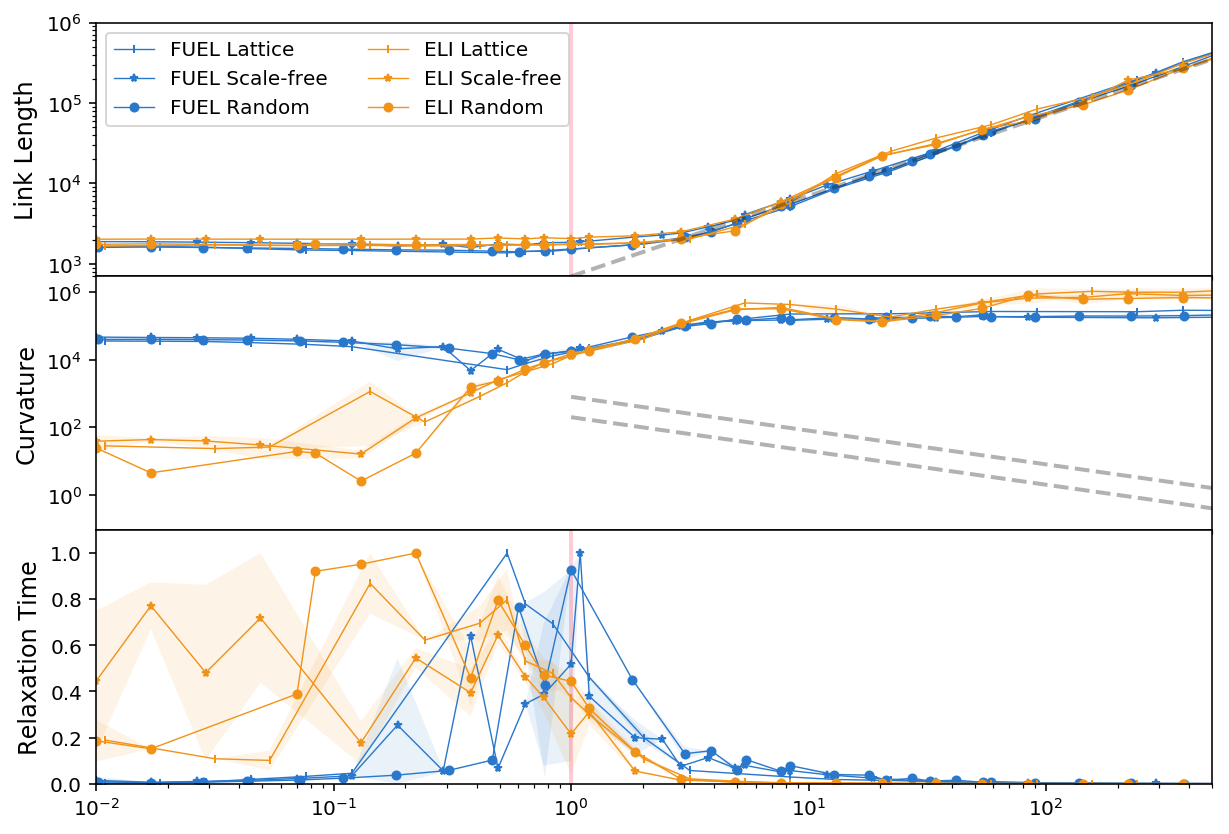

In [20]:

nn = 130#55
n1 = 3
fs = 12
x = logspace(0,3,5)
ep,h,h1 = 2e-2, 1e6,1e-3
mx = (1e-2,5.0e2)

y=array([1-ep,1+ep])
cl = ['#2a78cc','#f19317']
fig = figure(figsize=(10,7))
fig.subplots_adjust(hspace=0)
p = {'BA':'Scale-free', 'ER':'Random', 'Lat': 'Lattice'}
mk = {'BA':'*', 'ER':'o', 'Lat': '|'}
ms,lw =4,.7

for k,t in stats2.items():
    kw = {'label' : 'FUEL '+p[k],'c':cl[0],'marker':mk[k],'ms':ms,'lw':lw}
    subplot(n1,1,1)
    lz = bin_dat1(t['th'], t['lz'],nn)
    shade(lz,falpha = .1,**kw)
    #plot(*lz.T[:2],**kw)
    subplot(n1,1,2)
    c = bin_dat1(t['th'], t['cur']*t['lz'],nn, scale='')#(nn if k != 'ER' else 20))
    shade(c,falpha = .1,**kw)
    #plot(*c.T[:2],**kw)
    subplot(n1,1,3)
    t1 = (t['t']*t['lz']/maximum(1,t['th'])**2)
    t0 = bin_dat1(t['th'], t1/t1.max(),nn, scale='')
    shade(t0,falpha = .1,**kw)
    #plot(*t0.T[:2],**kw)
    
for k,t in stats2_fx.items():
    kw = {'label' : 'ELI '+p[k],'c':cl[1],'marker':mk[k],'ms':ms,'lw':lw}
    subplot(n1,1,1)
    lz = bin_dat1(t['th'], t['lz'],nn)
    shade(lz,falpha = .1,**kw)
    #plot(*lz.T[:2],**kw)
    subplot(n1,1,2)
    c = bin_dat1(t['th'], t['cur']*t['lz'],nn, scale='')#(nn if k != 'ER' else 20))
    shade(c,falpha = .1,**kw)
    #plot(*c.T[:2],**kw)
    subplot(n1,1,3)
    t1 = (t['t']*t['lz']/maximum(1,t['th'])**2)
    t0 = bin_dat1(t['th'], t1/t1.max(),nn, scale='')
    shade(t0,falpha = .1,**kw)
    #plot(*t0.T[:2],**kw)

a = .3
subplot(n1,1,1)
fill_between(y,[h,h], [1,1], facecolor = '#ff5577', alpha = a)
plot(x,7e2*x, 'k--', alpha = .3, lw=2)
ylabel('Link Length',fontsize=fs)
legend(ncol=2)
xscale('log')
yscale('log')
ylim(.7e3,1e6)
xlim(*mx)
xticks([])

subplot(n1,1,2)
#fill_between(y,[h,h], [h1,h1], facecolor = '#ff5577', alpha = a)
plot(x,2e2/x, 'k--', alpha = .3, lw=2)
plot(x,8e2/x, 'k--', alpha = .3, lw=2)
ylabel('Curvature',fontsize=fs)
xscale('log')
yscale('log')
#ylim(h1,5.2e2)
xlim(*mx)
xticks([])

subplot(n1,1,3)
fill_between(y,[h,h], [1e-5,1e-5], facecolor = '#ff5577', alpha = a)
ylabel('Relaxation Time',fontsize=fs)
xscale('log')
#ylim(1e0,2.5e4)
#ylim(0e0,.5e4)
ylim(0,1.1)

xlim(*mx)
#yscale('log')

In [ ]:

def bin_dat1(th,l, n=30,scale='log'):
    bb = {}
    mx = (th.min(),th.max())
    dx = log10(mx[1]/mx[0])/n
    #print dx
    for i in zip(th,l):
        k = int(log10(i[0])/dx)
        bb.setdefault(k ,[])
        bb[k] += [i[1]]
    return array([[10**(k*dx), ]+(lms(bb[k]) if scale=='log' else [mean(bb[k]),std(bb[k])] ) for k in sorted(bb)])
    #exp(mean(log(bb[k]))),exp(std(log(bb[k])))


In [ ]:
t0

In [341]:
#shade(lz,**kw)
kw

{'c': '#2a78cc', 'label': 'FUEL Lattice', 'lw': 0.7, 'marker': '|', 'ms': 4}

In [ ]:
# t = stats2_fx['ER']
t = stats2['Lat']


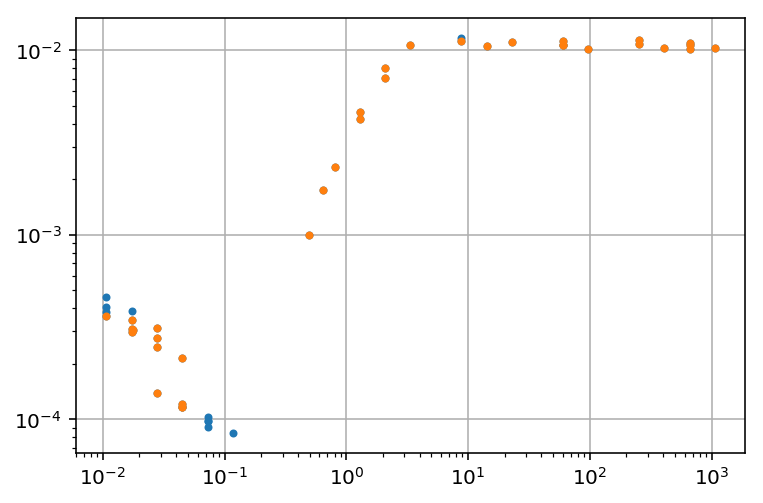

In [289]:
plot(t['th'],t['wz'],'.')
xscale('log')
yscale('log')
grid(1)
lms = lambda x: (exp(mean(log(x))), exp(std(log(x))))

f = 3.1
ix = where(t['th']>1*f)
m,s = lms(t['wz'][ix]) #t['wz'][ix].mean(),t['wz'][ix].std()
s1 = (t['wz'][ix] < m*s**2)*(t['wz'][ix] > m/s**2)  #m+s
idx= ix[0][where(s1)]
ix = where(t['th']<1/f)
m,s = lms(t['wz'][ix][where(t['wz'][ix]<.2e-2)]) #t['wz'][ix].mean(),t['wz'][ix].std()
s2 = (t['wz'][ix] < m*s)*(t['wz'][ix] > m/s)  #m+s
idx = concatenate((idx, ix[0][where(s2)], where((t['th']<=1*f)*(t['th']>=1/f))[0]))
#idx = where(s1*s2)
plot(t['th'][idx],t['wz'][idx],'.')
# plot(t['th'],t['cur'],'.')
# plot(t['th'][idx],t['cur'][idx],'.')

# xscale('log')
# yscale('log')

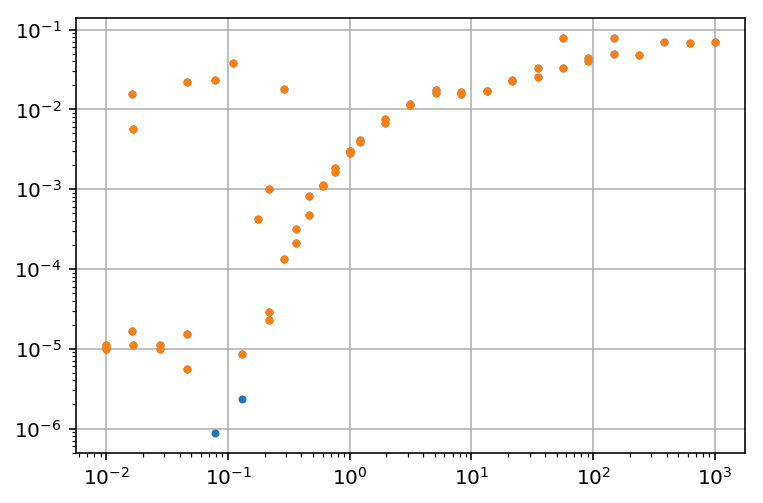

In [249]:
plot(t['th'],t['wz'],'.')
xscale('log')
yscale('log')
grid(1)
lms = lambda x: (exp(mean(log(x))), exp(std(log(x))))

f = 5.5
ix = where(t['th']>1*f)
m,s = lms(t['wz'][ix]) #t['wz'][ix].mean(),t['wz'][ix].std()
s1 = t['wz']< m*s**2  #m+s
ix = where(t['th']<1/f)
m,s = lms(t['wz'][ix]) #t['wz'][ix].mean(),t['wz'][ix].std()
s2 = t['wz']> m/s #m-s
idx = where(s1*s2)
plot(t['th'][idx],t['wz'][idx],'.')


In [332]:
sum([len(v['th']) for k,v in stats2.items()]),sum([len(v['th']) for k,v in stats2_fx.items()])

(169, 151)

## Similarity of layouts
While the link length seems to follow a clean line, the curvature does not. The question is, if all smulations have run under similar circumstances, 

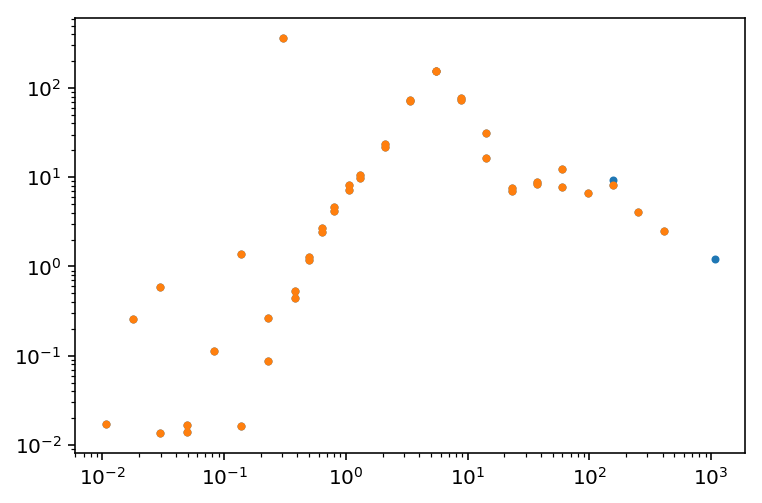

In [215]:
plot(t['th'],t['cur'],'.')
plot(t['th'][idx],t['cur'][idx],'.')

xscale('log')
yscale('log')

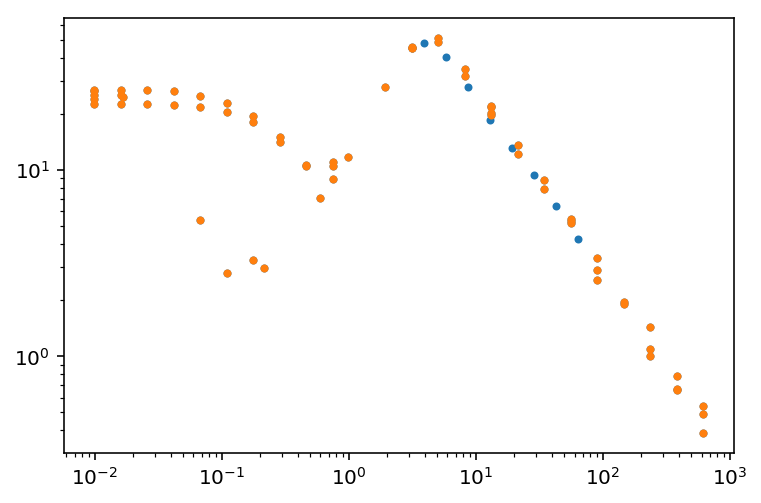

In [197]:
# idx = where((t['l']<8e4))
idx = where((['ER-4-' not in i for i in t['nam']]))
plot(t['th'],t['cur'],'.')
plot(t['th'][idx],t['cur'][idx],'.')

xscale('log')
yscale('log')

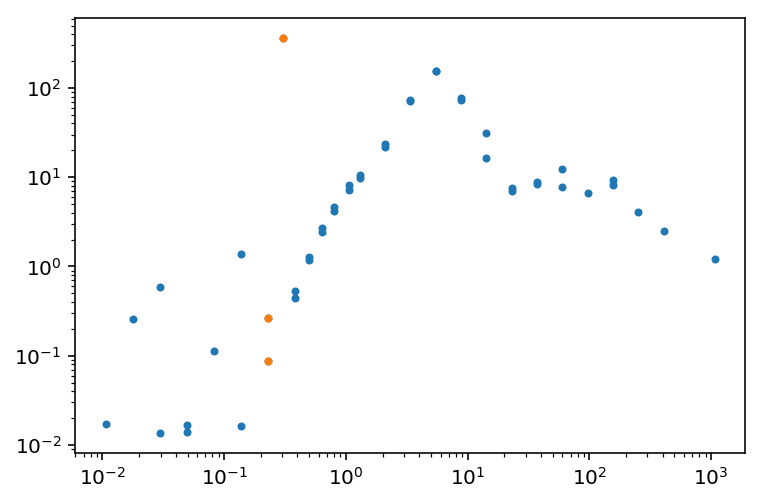

In [231]:
# idx = where((t['th']>50)* (t['th']<80))[0][:]
idx = where((t['th']>.2100)* (t['th']<.3200))[0]
plot(t['th'],t['cur'],'.')
plot(t['th'][idx],t['cur'][idx],'.')

xscale('log')
yscale('log')

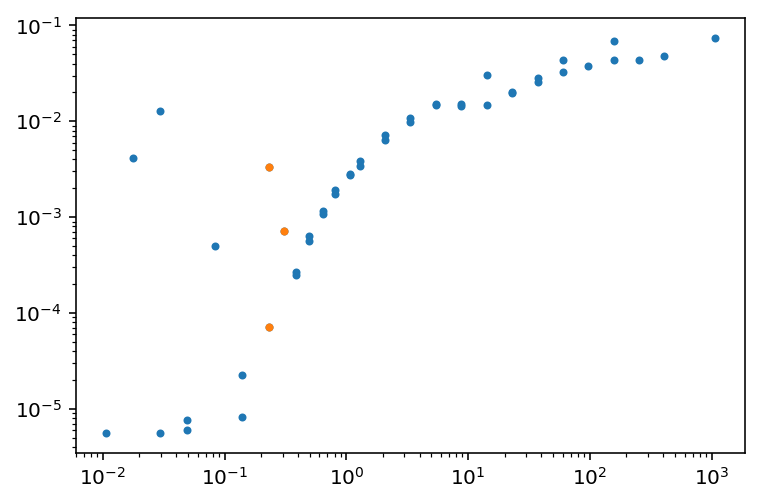

In [234]:
# idx = where((t['th']>50)* (t['th']<80))[0][:]
#idx = where((t['th']>.2100)* (t['th']<.3200))[0]
plot(t['th'],t['wz'],'.')
plot(t['th'][idx],t['wz'][idx],'.')

xscale('log')
yscale('log')

In [232]:
t['nam'][idx]

array(['Lat-0-n70-L156-th-r0.101-segs30-ka0.99-fixed.json',
       'Lat-2-n70-L156-th-r0.0759-segs30-ka1.32-fixed.json',
       'Lat-3-n70-L156-th-r0.0759-segs30-ka1.32-fixed.json'],
      dtype='|S51')

In [229]:
len(os.listdir(pth))/2, sum([len(os.listdir(i)) for i in [pth,'/home/nidami/3d/output/phase-100217/',\
    '/home/nidami/3d/output/phase-100917/','/home/nidami/3d/output/phase-101217/']])/2

(663, 1818)

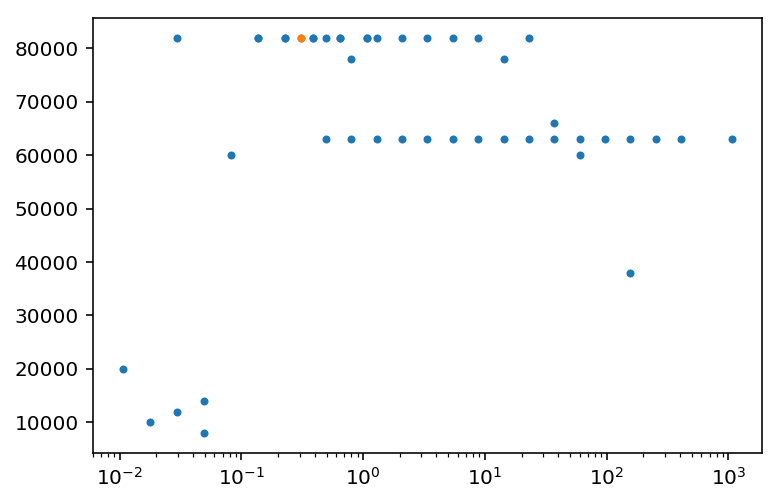

In [230]:
plot(t['th'],t['l'],'.')
plot(t['th'][idx],t['l'][idx],'.')

xscale('log')


In [71]:
l = t['nam'][idx]
l

array(['ER-6-n70-L136-th-r51.7-segs30-ka0.00193.json',
       'ER-8-n70-L136-th-r51.7-segs30-ka0.00193.json'],
      dtype='|S44')

In [183]:
def get_curv5(lnk,ep=1e-3):
    #lnk = net.links.points.reshape((len(net.edg),net.links.segs,net.pts.shape[-1]))
    dl = gradient(lnk)[1][:,1:-1]
    ddl = gradient(dl)[1]
    l0 = llen(lnk,1)[:,newaxis]/lnk.shape[1] 
    cur0 = 2*mag(cross(dl,ddl))/(mag(dl)**3+(.1*l0)**3) #maximum(mag(dl)**3,ep)#
    return cur0.mean(-1)#sqrt((cur0**2).mean(-1))


def get_lc1(fnam):
    net = json.load(open( fnam,'r'))
    lnk = array([v['points'] for k,v in net['links'].iteritems()])
    n = len(net['nodes']['positions'])
    l = len(lnk)
    rc = rs(n,l)
    return net['info']['links']['thickness']/rc,llen(lnk,1).sum(),get_curv5(lnk).sum(), wiza(net)
